To use venv, 
python -m ipykernel install --user --name=yoloenv


In [1]:
#@title Import necessary packages and set correct device

import os

import numpy as np
import torch
from tqdm.auto import tqdm
# from ultralytics import YOLO
from modules.yoloclip import YoloClip
from modules.refcocog import RefCOCOg, RefCOCOgSample

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("[INFO] GPU found, using GPU.")
else:
    device = torch.device("cpu")
    print("[INFO] No GPU found, using CPU instead.")


/home/dmmp/DeepLearningLab/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] GPU found, using GPU.


In [2]:
#@title Import RefCOCOg dataset and its train/val/test splits


data_path = "/media/dmmp/vid+backup/Data/refcocog"
dataset = RefCOCOg(ds_path=data_path)

train_ds = RefCOCOg(ds_path=data_path, split='train')
val_ds = RefCOCOg(ds_path=data_path, split='val')
test_ds = RefCOCOg(ds_path=data_path, split='test')

print(f"Dataset Size: {len(dataset)}\n")
print(f"Train size: {len(train_ds)}")
print(f"Val size:   {len(val_ds)}")
print(f"Test size:  {len(test_ds)}")


Dataset Size: 49822

Train size: 42226
Val size:   2573
Test size:  5023


In [3]:
#@title Initialize YoloClip pipeline

yoloclip = YoloClip(device=device, quiet=False, dist_metric="cosine", categories=dataset.categories)


[INFO] Running YOLO on the image...



image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000277956.jpg: 480x640 3 persons, 1 frisbee, 23.7ms
Speed: 0.6ms preprocess, 23.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


[INFO] YOLO found 4 objects
[INFO] Running CLIP on the prompt...
[INFO] true: person | predicted: person


/home/dmmp/DeepLearningLab/visual-grounding/modules/yoloclip.py:163: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  torch.tensor([gt_bbox])
/home/dmmp/DeepLearningLab/visual-grounding/modules/yoloclip.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.text(pred_bbox[0], pred_bbox[1], "predicted", color=(1, 1, 1),
/home/dmmp/DeepLearningLab/visual-grounding/modules/yoloclip.py:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.text(gt_bbox[0], gt_bbox[3], "true", color=(1, 1, 1),


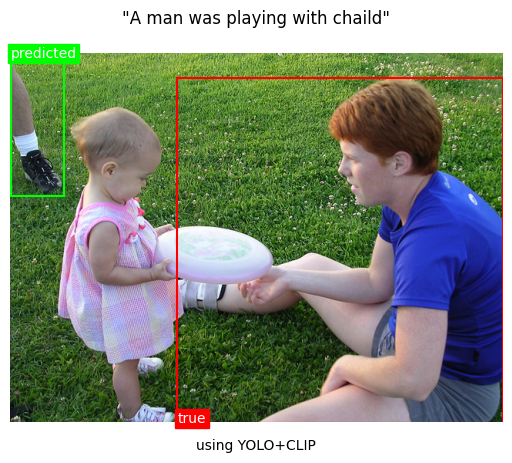


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000277956.jpg: 480x640 3 persons, 1 frisbee, 24.2ms
Speed: 0.5ms preprocess, 24.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


[INFO] Running YOLO on the image...
[INFO] YOLO found 4 objects
[INFO] Running CLIP on the prompt...
[INFO] true: person | predicted: person


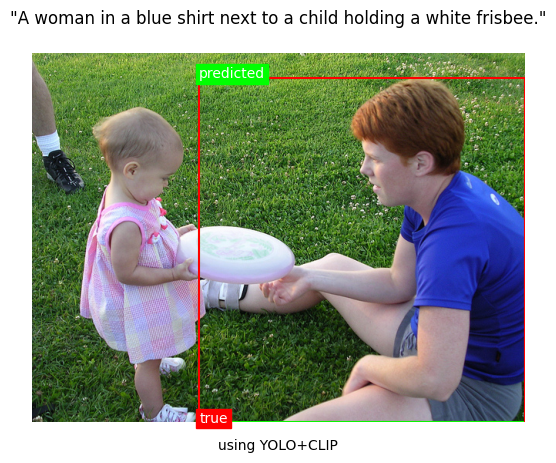

In [4]:
#@tile Test YoloClip on a random sample

%matplotlib inline

idx = np.random.randint(0, len(dataset))

sample = RefCOCOgSample(**dataset[idx])

for sentence in sample.sentences:
    yoloclip(sample, sentence, show=True)


---

In [5]:
#@title Function definition to test visual grounding with a given pipeline

def visual_grounding_test(vg_pipeline, dataset):
    scores = list()

    for sample in tqdm(dataset, desc=f"Testing on {len(dataset)} images",position=0, leave=True):

        sample = RefCOCOgSample(**sample)

        for sentence in sample.sentences:

            try:
                sc = vg_pipeline(sample, sentence, show=False)
            except ValueError:
                continue

            scores.append(sc)

    for metric in scores[0].keys():
        avg_metric = np.mean([score[metric] for score in scores])

        print("Avg. {}: {:.3f}".format(metric, avg_metric))


In [6]:
#@title Test YoloClip on the test set

yoloclip.quiet = True

visual_grounding_test(yoloclip, test_ds)


Testing on 5023 images:   0%|                          | 0/5023 [00:00<?, ?it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000380440.jpg: 384x640 2 persons, 1 backpack, 2 skiss, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000380440.jpg: 384x640 2 persons, 1 backpack, 2 skiss, 17.7ms
Speed: 0.4ms preprocess, 17.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   0%|                  | 1/5023 [00:00<13:31,  6.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000419645.jpg: 448x640 3 trucks, 25.1ms
Speed: 0.6ms preprocess, 25.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000419645.jpg: 448x640 3 trucks, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.5ms post

Testing on 5023 images:   0%|                 | 15/5023 [00:02<14:19,  5.83it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000276740.jpg: 480x640 2 hot dogs, 23.7ms
Speed: 0.4ms preprocess, 23.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000276740.jpg: 480x640 2 hot dogs, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   0%|                 | 16/5023 [00:02<13:13,  6.31it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000271641.jpg: 448x640 3 persons, 1 backpack, 2 skiss, 20.2ms
Speed: 0.5ms preprocess, 20.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000271641.jpg: 448x640 3 persons, 1 backpack, 2 skiss, 19.8ms
Speed: 0.6ms preprocess, 19.8ms inference, 0.6ms 

Speed: 0.5ms preprocess, 14.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   1%|                 | 31/5023 [00:05<14:24,  5.78it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000108210.jpg: 448x640 4 airplanes, 7 trucks, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000108210.jpg: 448x640 4 airplanes, 7 trucks, 20.2ms
Speed: 0.6ms preprocess, 20.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   1%|                 | 32/5023 [00:05<15:36,  5.33it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000298160.jpg: 640x640 1 person, 2 buss, 1 horse, 19.5ms
Speed: 0.6ms preprocess, 19.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_

Testing on 5023 images:   1%|▏                | 46/5023 [00:08<15:11,  5.46it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000050961.jpg: 480x640 5 ovens, 23.0ms
Speed: 0.5ms preprocess, 23.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000050961.jpg: 480x640 5 ovens, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   1%|▏                | 47/5023 [00:08<14:41,  5.65it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000088653.jpg: 480x640 2 persons, 1 cell phone, 23.1ms
Speed: 0.6ms preprocess, 23.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000088653.jpg: 480x640 2 persons, 1 cell phone, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.5ms postprocess per imag

Testing on 5023 images:   1%|▏                | 61/5023 [00:11<15:29,  5.34it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000112226.jpg: 480x640 12 persons, 5 umbrellas, 1 sandwich, 4 chairs, 22.4ms
Speed: 0.9ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000112226.jpg: 480x640 12 persons, 5 umbrellas, 1 sandwich, 4 chairs, 21.8ms
Speed: 0.8ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   1%|▏                | 62/5023 [00:11<18:59,  4.35it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000372319.jpg: 480x640 3 persons, 2 benchs, 1 handbag, 1 bottle, 1 cell phone, 22.4ms
Speed: 0.4ms preprocess, 22.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000372319.jpg: 48

Testing on 5023 images:   2%|▎                | 77/5023 [00:13<12:33,  6.57it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000231878.jpg: 512x640 5 persons, 4 umbrellas, 2 handbags, 17.5ms
Speed: 0.5ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000231878.jpg: 512x640 5 persons, 4 umbrellas, 2 handbags, 16.6ms
Speed: 0.6ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   2%|▎                | 78/5023 [00:14<14:03,  5.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000436306.jpg: 640x640 2 persons, 3 bananas, 19.6ms
Speed: 0.6ms preprocess, 19.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000436306.jpg: 640x640 2 persons, 3 bananas, 18.7ms
Speed: 0.6ms preproce

Speed: 0.5ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000285486.jpg: 480x640 5 persons, 4 cups, 5 laptops, 2 books, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   2%|▎                | 92/5023 [00:16<17:14,  4.77it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000298160.jpg: 640x640 1 person, 2 buss, 1 horse, 18.2ms
Speed: 0.6ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000298160.jpg: 640x640 1 person, 2 buss, 1 horse, 18.8ms
Speed: 0.6ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   2%|▎                | 93/5023 [00:17<15:52,  5.18it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/im

Speed: 0.4ms preprocess, 16.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000447297.jpg: 384x640 1 person, 3 cars, 1 motorcycle, 1 fire hydrant, 16.9ms
Speed: 0.4ms preprocess, 16.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   2%|▎               | 107/5023 [00:19<13:12,  6.21it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000326357.jpg: 416x640 2 birds, 22.3ms
Speed: 0.4ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000326357.jpg: 416x640 2 birds, 20.6ms
Speed: 0.4ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   2%|▎               | 108/5023 [00:19<12:30,  6.55it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_0000000

Testing on 5023 images:   2%|▍               | 123/5023 [00:22<10:44,  7.60it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000204759.jpg: 480x640 2 persons, 1 elephant, 1 bowl, 22.3ms
Speed: 0.6ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000204759.jpg: 480x640 2 persons, 1 elephant, 1 bowl, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   2%|▍               | 124/5023 [00:22<11:23,  7.17it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000053150.jpg: 448x640 2 persons, 4 cars, 1 elephant, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000053150.jpg: 448x640 2 persons, 4 cars, 1 elephant, 21.6ms
Speed: 0.5ms 

Speed: 0.5ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   3%|▍               | 138/5023 [00:24<15:18,  5.32it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000252025.jpg: 640x480 10 persons, 3 giraffes, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000252025.jpg: 640x480 10 persons, 3 giraffes, 14.2ms
Speed: 0.6ms preprocess, 14.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   3%|▍               | 139/5023 [00:25<16:25,  4.95it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000446864.jpg: 512x640 2 knifes, 3 bowls, 1 carrot, 1 chair, 3 dining tables, 17.6ms
Speed: 0.5ms preprocess, 17.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/r

Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000289211.jpg: 640x480 1 cat, 1 dog, 1 couch, 3 books, 14.7ms
Speed: 0.4ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   3%|▍               | 154/5023 [00:27<13:40,  5.93it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000272255.jpg: 640x544 6 persons, 2 cars, 1 bus, 5 umbrellas, 5 handbags, 18.1ms
Speed: 0.7ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000272255.jpg: 640x544 6 persons, 2 cars, 1 bus, 5 umbrellas, 5 handbags, 16.0ms
Speed: 0.5ms preprocess, 16.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   3%|▍               | 155/5023 [00:28<16:23,  4.95it/s]
image 1/

Speed: 0.8ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000520767.jpg: 448x640 3 persons, 1 giraffe, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000520767.jpg: 448x640 3 persons, 1 giraffe, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   3%|▌               | 170/5023 [00:30<13:54,  5.81it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000101882.jpg: 512x640 2 persons, 2 motorcycles, 17.6ms
Speed: 0.5ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000101882.jpg: 512x640 2 persons, 2 motorcycles, 16.9ms
Speed: 0.6ms preprocess,


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000406895.jpg: 448x640 5 persons, 2 skateboards, 1 cell phone, 22.2ms
Speed: 0.7ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   4%|▌               | 184/5023 [00:33<15:33,  5.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000131127.jpg: 448x640 5 persons, 2 bananas, 21.3ms
Speed: 0.4ms preprocess, 21.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000131127.jpg: 448x640 5 persons, 2 bananas, 21.0ms
Speed: 0.5ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   4%|▌               | 185/5023 [00:33<15:26,  5.22it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000498706.jpg: 448x640 2 persons, 2 skiss, 20.4ms
Speed: 0.5ms preprocess, 20.4ms i

Speed: 0.5ms preprocess, 21.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   4%|▋               | 199/5023 [00:36<14:38,  5.49it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000200404.jpg: 480x640 5 persons, 4 cars, 2 trucks, 1 suitcase, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000200404.jpg: 480x640 5 persons, 4 cars, 2 trucks, 1 suitcase, 22.7ms
Speed: 0.4ms preprocess, 22.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   4%|▋               | 200/5023 [00:36<15:47,  5.09it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000256364.jpg: 480x640 2 trains, 1 traffic light, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/

Speed: 0.7ms preprocess, 23.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000416907.jpg: 480x640 2 persons, 1 bottle, 1 bowl, 1 bed, 1 toothbrush, 22.7ms
Speed: 0.7ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   4%|▋               | 215/5023 [00:39<13:49,  5.80it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000078482.jpg: 480x640 3 persons, 1 tie, 1 cake, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000078482.jpg: 480x640 3 persons, 1 tie, 1 cake, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   4%|▋               | 216/5023 [00:39<13:46,  5.82it/s]
image 1/1 /media/dmmp/vid+backup/Data/re

Speed: 0.5ms preprocess, 22.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   5%|▋               | 230/5023 [00:41<14:31,  5.50it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000458124.jpg: 640x480 4 persons, 1 bottle, 1 wine glass, 1 pizza, 3 chairs, 4 dining tables, 15.2ms
Speed: 0.5ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000458124.jpg: 640x480 4 persons, 1 bottle, 1 wine glass, 1 pizza, 3 chairs, 4 dining tables, 14.9ms
Speed: 0.5ms preprocess, 14.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   5%|▋               | 231/5023 [00:42<16:18,  4.90it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000217276.jpg: 448x640 3 persons, 1 bench, 2 umbrellas, 4 cell phones, 21.9ms
Speed: 0.6ms preprocess, 21.9ms inference, 0.5ms p


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000082228.jpg: 480x640 3 persons, 1 wine glass, 2 cups, 1 fork, 1 bowl, 1 sandwich, 1 donut, 1 dining table, 21.5ms
Speed: 0.4ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000082228.jpg: 480x640 3 persons, 1 wine glass, 2 cups, 1 fork, 1 bowl, 1 sandwich, 1 donut, 1 dining table, 21.7ms
Speed: 0.4ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   5%|▊               | 245/5023 [00:44<18:28,  4.31it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000149916.jpg: 544x640 2 persons, 1 sports ball, 1 baseball glove, 24.0ms
Speed: 0.6ms preprocess, 24.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000149916.jpg: 544x640 2 person


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000048267.jpg: 448x640 16 persons, 12 wine glasss, 2 cups, 1 knife, 1 cake, 9 chairs, 2 dining tables, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   5%|▊               | 260/5023 [00:47<22:47,  3.48it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000269245.jpg: 480x640 2 motorcycles, 1 dog, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000269245.jpg: 480x640 2 motorcycles, 1 dog, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   5%|▊               | 261/5023 [00:47<19:30,  4.07it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000085939.jpg: 480x640 4 vases, 22.6ms
Spee

Testing on 5023 images:   5%|▉               | 275/5023 [00:50<14:39,  5.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000055733.jpg: 480x640 4 persons, 3 snowboards, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000055733.jpg: 480x640 4 persons, 3 snowboards, 20.6ms
Speed: 0.6ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   5%|▉               | 276/5023 [00:50<14:33,  5.43it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000263810.jpg: 640x384 3 persons, 1 handbag, 20 apples, 1 chair, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000263810.jpg: 640x384 3 persons, 1 handbag, 20 apples, 1 chair, 13.8ms
Spe

Testing on 5023 images:   6%|▉               | 290/5023 [00:53<14:53,  5.29it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000342807.jpg: 480x640 3 persons, 1 bench, 1 handbag, 5 wine glasss, 2 knifes, 4 chairs, 2 dining tables, 24.0ms
Speed: 0.5ms preprocess, 24.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000342807.jpg: 480x640 3 persons, 1 bench, 1 handbag, 5 wine glasss, 2 knifes, 4 chairs, 2 dining tables, 21.1ms
Speed: 0.7ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   6%|▉               | 291/5023 [00:53<17:10,  4.59it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000234616.jpg: 448x640 3 persons, 2 baseball gloves, 22.5ms
Speed: 0.6ms preprocess, 22.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refco

Testing on 5023 images:   6%|▉               | 305/5023 [00:56<15:19,  5.13it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000306454.jpg: 448x640 1 knife, 2 carrots, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000306454.jpg: 448x640 1 knife, 2 carrots, 20.4ms
Speed: 0.7ms preprocess, 20.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   6%|▉               | 306/5023 [00:56<14:16,  5.51it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000455791.jpg: 640x384 4 persons, 1 baseball glove, 13.9ms
Speed: 0.4ms preprocess, 13.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000455791.jpg: 640x384 4 persons, 1 baseball glove, 14.1ms
Speed: 0.5ms preprocess, 14.1ms inferen

Testing on 5023 images:   6%|█               | 321/5023 [00:59<13:38,  5.74it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000217276.jpg: 448x640 3 persons, 1 bench, 2 umbrellas, 4 cell phones, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000217276.jpg: 448x640 3 persons, 1 bench, 2 umbrellas, 4 cell phones, 21.2ms
Speed: 0.6ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   6%|█               | 322/5023 [00:59<14:29,  5.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000105666.jpg: 384x640 2 persons, 1 cup, 1 fork, 4 donuts, 2 dining tables, 16.1ms
Speed: 0.5ms preprocess, 16.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000105666.jpg: 384

Speed: 0.6ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000322445.jpg: 640x480 6 persons, 2 backpacks, 1 suitcase, 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   7%|█               | 337/5023 [01:02<14:08,  5.52it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000093176.jpg: 640x640 1 person, 1 cat, 2 beds, 19.1ms
Speed: 0.9ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000093176.jpg: 640x640 1 person, 1 cat, 2 beds, 18.0ms
Speed: 0.9ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   7%|█               | 338/5023 [01:02<13:33,  5.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/CO

Testing on 5023 images:   7%|█               | 351/5023 [01:04<15:09,  5.14it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000005782.jpg: 480x640 2 dogs, 21.8ms
Speed: 0.6ms preprocess, 21.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000005782.jpg: 480x640 2 dogs, 20.4ms
Speed: 0.4ms preprocess, 20.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   7%|█               | 352/5023 [01:04<13:42,  5.68it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000379564.jpg: 480x640 3 cups, 2 forks, 2 knifes, 2 spoons, 2 bowls, 1 chair, 1 dining table, 20.6ms
Speed: 0.5ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000379564.jpg: 480x640 3 cups, 2 forks, 2 knifes, 2 spoons, 2 bowls, 1 chair, 1 

Speed: 0.5ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   7%|█▏              | 367/5023 [01:07<12:13,  6.35it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000114202.jpg: 640x480 2 giraffes, 15.2ms
Speed: 0.6ms preprocess, 15.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000114202.jpg: 640x480 2 giraffes, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   7%|█▏              | 368/5023 [01:07<11:43,  6.61it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000364653.jpg: 448x640 2 sheeps, 22.8ms
Speed: 0.4ms preprocess, 22.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000364653.jpg: 448x640 2 sheeps, 20.

Speed: 0.4ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000287507.jpg: 640x448 1 cup, 1 knife, 1 bowl, 4 sandwichs, 1 broccoli, 1 dining table, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   8%|█▏              | 383/5023 [01:10<18:09,  4.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000273362.jpg: 640x320 3 persons, 1 frisbee, 13.5ms
Speed: 0.4ms preprocess, 13.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000273362.jpg: 640x320 3 persons, 1 frisbee, 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   8%|█▏              | 384/5023 [01:10<15:41,  4.93it/s]
image 1/1 /media/dmmp/vid+backup/

Speed: 0.5ms preprocess, 16.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000554168.jpg: 512x640 3 zebras, 3 giraffes, 17.5ms
Speed: 0.5ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   8%|█▎              | 398/5023 [01:13<13:52,  5.56it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000197503.jpg: 480x640 5 persons, 1 cup, 11 chairs, 2 tvs, 2 remotes, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000197503.jpg: 480x640 5 persons, 1 cup, 11 chairs, 2 tvs, 2 remotes, 21.7ms
Speed: 0.6ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   8%|█▎              | 399/5023 [01:13<17:01,  4.52it/s]
image 1/1 /media/dmmp/vid+


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000162645.jpg: 640x640 4 persons, 3 forks, 4 pizzas, 1 chair, 1 dining table, 18.0ms
Speed: 0.6ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   8%|█▎              | 413/5023 [01:16<14:10,  5.42it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000011697.jpg: 640x480 1 person, 4 cars, 1 truck, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000011697.jpg: 640x480 1 person, 4 cars, 1 truck, 14.8ms
Speed: 0.4ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   8%|█▎              | 414/5023 [01:16<13:19,  5.77it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000121445.jpg: 480x640 11 persons, 2 benchs, 1 baseball ba

Speed: 0.7ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000260448.jpg: 480x640 4 persons, 1 backpack, 1 handbag, 4 bottles, 2 wine glasss, 1 chair, 1 bed, 22.9ms
Speed: 0.9ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   9%|█▎              | 430/5023 [01:18<15:06,  5.07it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000456176.jpg: 512x640 1 dog, 3 cows, 16.8ms
Speed: 0.5ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000456176.jpg: 512x640 1 dog, 3 cows, 17.2ms
Speed: 0.5ms preprocess, 17.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   9%|█▎              | 431/5023 [01:19<13:57,  5.48it/s]
image 1/1 /media/dmmp/vid+backup/Dat

Testing on 5023 images:   9%|█▍              | 445/5023 [01:21<16:02,  4.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000566968.jpg: 480x640 2 spoons, 3 bowls, 2 pizzas, 1 dining table, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000566968.jpg: 480x640 2 spoons, 3 bowls, 2 pizzas, 1 dining table, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   9%|█▍              | 446/5023 [01:21<15:57,  4.78it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000366795.jpg: 480x640 1 person, 1 handbag, 1 banana, 22.1ms
Speed: 0.4ms preprocess, 22.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000274139.jpg: 640x448 1 dog, 14.8ms
Speed: 0.

Testing on 5023 images:   9%|█▍              | 461/5023 [01:24<12:43,  5.98it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000400740.jpg: 480x640 2 persons, 2 buss, 23.7ms
Speed: 0.6ms preprocess, 23.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000400740.jpg: 480x640 2 persons, 2 buss, 22.3ms
Speed: 0.4ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   9%|█▍              | 462/5023 [01:24<12:19,  6.17it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000416612.jpg: 640x448 2 persons, 1 tie, 2 cakes, 1 dining table, 14.9ms
Speed: 0.6ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000416612.jpg: 640x448 2 persons, 1 tie, 2 cakes, 1 dining table, 14.0ms
Speed: 0.4ms 

Speed: 0.4ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000148937.jpg: 640x448 3 persons, 1 tie, 1 cup, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:   9%|█▌              | 477/5023 [01:27<12:58,  5.84it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442062.jpg: 480x640 3 chairs, 4 teddy bears, 22.1ms
Speed: 0.4ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442062.jpg: 480x640 3 chairs, 4 teddy bears, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  10%|█▌              | 478/5023 [01:27<13:10,  5.75it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train201

Speed: 0.6ms preprocess, 14.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  10%|█▌              | 492/5023 [01:30<11:53,  6.35it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000236260.jpg: 640x448 3 persons, 1 umbrella, 1 bottle, 1 knife, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000236260.jpg: 640x448 3 persons, 1 umbrella, 1 bottle, 1 knife, 14.8ms
Speed: 0.4ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  10%|█▌              | 493/5023 [01:30<12:06,  6.24it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000503777.jpg: 448x640 1 chair, 2 couchs, 3 potted plants, 21.1ms
Speed: 0.6ms preprocess, 21.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/

Speed: 0.4ms preprocess, 22.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000274499.jpg: 480x640 2 persons, 2 ties, 2 bottles, 1 cup, 1 laptop, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  10%|█▌              | 507/5023 [01:33<13:49,  5.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000173925.jpg: 640x320 4 persons, 1 tennis racket, 12.1ms
Speed: 0.6ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000245326.jpg: 448x640 3 persons, 3 horses, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000245326.jpg: 448x640 3 persons, 3 horses, 21.3ms
Spe

Speed: 0.4ms preprocess, 21.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  10%|█▋              | 523/5023 [01:35<13:09,  5.70it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000172957.jpg: 448x640 2 persons, 1 chair, 1 laptop, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000172957.jpg: 448x640 2 persons, 1 chair, 1 laptop, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  10%|█▋              | 524/5023 [01:36<12:39,  5.92it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000524991.jpg: 512x640 1 truck, 3 zebras, 17.7ms
Speed: 0.4ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_trai

Speed: 0.4ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000016669.jpg: 448x640 2 tvs, 1 laptop, 1 mouse, 1 keyboard, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  11%|█▋              | 538/5023 [01:38<13:58,  5.35it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000072947.jpg: 448x640 3 persons, 1 frisbee, 21.7ms
Speed: 0.4ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000072947.jpg: 448x640 3 persons, 1 frisbee, 21.8ms
Speed: 0.4ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  11%|█▋              | 539/5023 [01:38<13:19,  5.61it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_t

Testing on 5023 images:  11%|█▊              | 553/5023 [01:41<15:47,  4.72it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000286116.jpg: 448x640 2 persons, 2 wine glasss, 2 chairs, 1 couch, 3 laptops, 21.5ms
Speed: 0.4ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000286116.jpg: 448x640 2 persons, 2 wine glasss, 2 chairs, 1 couch, 3 laptops, 20.4ms
Speed: 0.5ms preprocess, 20.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  11%|█▊              | 554/5023 [01:41<15:27,  4.82it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000230321.jpg: 480x640 1 bottle, 3 beds, 23.1ms
Speed: 0.5ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000304088.jpg: 320x640 4 persons, 2 b

Speed: 0.6ms preprocess, 22.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000311088.jpg: 448x640 3 persons, 3 cars, 1 truck, 1 umbrella, 1 tie, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  11%|█▊              | 569/5023 [01:44<13:50,  5.36it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000555683.jpg: 480x640 2 persons, 9 sports balls, 4 tennis rackets, 23.6ms
Speed: 0.5ms preprocess, 23.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  11%|█▊              | 570/5023 [01:44<12:37,  5.88it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000237367.jpg: 480x640 4 persons, 1 umbrella, 3 wine glasss, 3 chairs, 2 dining tables, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 1.1ms postprocess per image at shape (1,

Speed: 0.5ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000299959.jpg: 448x640 10 persons, 2 boats, 1 dog, 1 backpack, 1 chair, 22.3ms
Speed: 0.4ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  12%|█▊              | 585/5023 [01:47<13:43,  5.39it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000215289.jpg: 480x640 3 sheeps, 23.8ms
Speed: 0.4ms preprocess, 23.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000215289.jpg: 480x640 3 sheeps, 22.4ms
Speed: 0.4ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  12%|█▊              | 586/5023 [01:47<13:01,  5.68it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_0000

Speed: 0.9ms preprocess, 26.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442878.jpg: 576x640 3 couchs, 1 tv, 3 books, 1 vase, 25.5ms
Speed: 0.8ms preprocess, 25.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  12%|█▉              | 600/5023 [01:50<16:45,  4.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000089208.jpg: 448x640 2 persons, 2 horses, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000089208.jpg: 448x640 2 persons, 2 horses, 21.3ms
Speed: 0.4ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  12%|█▉              | 601/5023 [01:50<15:13,  4.84it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train201

Speed: 0.4ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000163598.jpg: 480x640 3 persons, 1 couch, 1 dining table, 1 tv, 1 book, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  12%|█▉              | 615/5023 [01:52<14:00,  5.24it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000453553.jpg: 640x480 3 persons, 1 cup, 2 cakes, 1 chair, 1 dining table, 1 vase, 14.9ms
Speed: 0.4ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000453553.jpg: 640x480 3 persons, 1 cup, 2 cakes, 1 chair, 1 dining table, 1 vase, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  12%|█▉              | 616/50

Speed: 0.4ms preprocess, 13.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██              | 630/5023 [01:55<11:22,  6.43it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000380889.jpg: 448x640 1 person, 1 tv, 1 laptop, 22.3ms
Speed: 0.4ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000380889.jpg: 448x640 1 person, 1 tv, 1 laptop, 20.0ms
Speed: 0.4ms preprocess, 20.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██              | 631/5023 [01:55<11:20,  6.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000204053.jpg: 448x640 2 persons, 3 trains, 1 handbag, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO

Speed: 0.4ms preprocess, 22.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000020619.jpg: 480x640 3 bottles, 1 cup, 1 fork, 5 donuts, 3 cakes, 1 dining table, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██              | 646/5023 [01:58<14:50,  4.92it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000025237.jpg: 640x512 2 persons, 2 bottles, 1 sink, 2 toothbrushs, 15.3ms
Speed: 0.5ms preprocess, 15.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000025237.jpg: 640x512 2 persons, 2 bottles, 1 sink, 2 toothbrushs, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██              | 647/5023 [01:58<14:26,  5

Speed: 0.5ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██              | 661/5023 [02:01<12:03,  6.03it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000036445.jpg: 448x640 3 donuts, 1 dining table, 21.7ms
Speed: 0.7ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000036445.jpg: 448x640 3 donuts, 1 dining table, 20.5ms
Speed: 0.6ms preprocess, 20.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██              | 662/5023 [02:01<11:36,  6.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000365527.jpg: 640x416 2 persons, 2 bicycles, 1 motorcycle, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images

Speed: 0.5ms preprocess, 24.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000053370.jpg: 480x640 2 persons, 3 motorcycles, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██▏             | 677/5023 [02:03<13:19,  5.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000446661.jpg: 448x640 4 airplanes, 1 truck, 21.0ms
Speed: 0.5ms preprocess, 21.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000446661.jpg: 448x640 4 airplanes, 1 truck, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  13%|██▏             | 678/5023 [02:04<12:51,  5.63it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000

Testing on 5023 images:  14%|██▏             | 691/5023 [02:06<11:30,  6.27it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000502407.jpg: 480x640 4 bowls, 2 sandwichs, 4 broccolis, 3 carrots, 2 cakes, 24.4ms
Speed: 0.6ms preprocess, 24.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000502407.jpg: 480x640 4 bowls, 2 sandwichs, 4 broccolis, 3 carrots, 2 cakes, 21.6ms
Speed: 0.4ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  14%|██▏             | 692/5023 [02:06<13:50,  5.21it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000377456.jpg: 448x640 2 persons, 2 benchs, 2 backpacks, 1 tennis racket, 1 chair, 21.3ms
Speed: 0.7ms preprocess, 21.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_

Speed: 1.0ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  14%|██▎             | 707/5023 [02:09<13:11,  5.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000410708.jpg: 480x640 1 bottle, 3 cups, 1 fork, 2 knifes, 1 bowl, 6 donuts, 1 dining table, 21.9ms
Speed: 0.6ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000410708.jpg: 480x640 1 bottle, 3 cups, 1 fork, 2 knifes, 1 bowl, 6 donuts, 1 dining table, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  14%|██▎             | 708/5023 [02:09<14:42,  4.89it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000451119.jpg: 640x480 2 persons, 1 couch, 1 tv, 4 remotes, 14.9ms
Speed: 0.4ms preprocess, 14.9ms inference, 0.5ms postprocess pe

Testing on 5023 images:  14%|██▎             | 722/5023 [02:12<11:17,  6.34it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000160291.jpg: 608x640 5 persons, 2 skiss, 26.3ms
Speed: 0.7ms preprocess, 26.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000160291.jpg: 608x640 5 persons, 2 skiss, 25.5ms
Speed: 0.6ms preprocess, 25.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  14%|██▎             | 723/5023 [02:12<11:58,  5.99it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561818.jpg: 448x640 2 giraffes, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561818.jpg: 448x640 2 giraffes, 21.0ms
Speed: 0.4ms preprocess, 21.0ms inference, 0.8ms postprocess per image at

Speed: 0.5ms preprocess, 23.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000133384.jpg: 480x640 2 persons, 1 bowl, 1 couch, 2 laptops, 2 remotes, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  15%|██▎             | 738/5023 [02:15<11:37,  6.14it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000328917.jpg: 480x640 3 persons, 1 sheep, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000328917.jpg: 480x640 3 persons, 1 sheep, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  15%|██▎             | 739/5023 [02:15<11:32,  6.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/image

Testing on 5023 images:  15%|██▍             | 752/5023 [02:17<13:23,  5.32it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000313569.jpg: 480x640 2 persons, 1 tv, 2 remotes, 2 books, 22.4ms
Speed: 0.6ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000313569.jpg: 480x640 2 persons, 1 tv, 2 remotes, 2 books, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  15%|██▍             | 753/5023 [02:17<13:17,  5.35it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000356922.jpg: 640x480 3 persons, 1 cup, 1 dining table, 3 laptops, 1 mouse, 14.9ms
Speed: 0.5ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  15%|██▍             | 754/5023 [02:18<11:34,  6.14it/s]
image 1/1 /media/dmmp/vid+backu

Testing on 5023 images:  15%|██▍             | 767/5023 [02:20<13:16,  5.34it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000425141.jpg: 640x480 1 person, 4 bottles, 2 refrigerators, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000425141.jpg: 640x480 1 person, 4 bottles, 2 refrigerators, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  15%|██▍             | 768/5023 [02:21<12:48,  5.54it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000310360.jpg: 480x640 5 persons, 1 handbag, 1 bottle, 2 wine glasss, 1 chair, 1 dining table, 3 tvs, 2 remotes, 22.1ms
Speed: 0.8ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_0000

Testing on 5023 images:  16%|██▍             | 782/5023 [02:23<13:25,  5.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000361197.jpg: 480x640 3 cups, 1 bowl, 1 sandwich, 23.1ms
Speed: 0.4ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000361197.jpg: 480x640 3 cups, 1 bowl, 1 sandwich, 20.9ms
Speed: 0.5ms preprocess, 20.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  16%|██▍             | 783/5023 [02:24<12:58,  5.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000371824.jpg: 640x640 2 persons, 2 ties, 19.2ms
Speed: 0.5ms preprocess, 19.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000371824.jpg: 640x640 2 persons, 2 ties, 18.4ms
Speed: 0.6ms preprocess, 18.4ms inference, 

Testing on 5023 images:  16%|██▌             | 797/5023 [02:26<12:58,  5.43it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000024095.jpg: 480x640 1 sheep, 2 giraffes, 23.5ms
Speed: 0.7ms preprocess, 23.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000024095.jpg: 480x640 1 sheep, 2 giraffes, 21.8ms
Speed: 0.7ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  16%|██▌             | 798/5023 [02:26<11:58,  5.88it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000253796.jpg: 512x640 2 birds, 2 giraffes, 16.8ms
Speed: 0.6ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000253796.jpg: 512x640 2 birds, 2 giraffes, 17.3ms
Speed: 0.5ms preprocess, 17.3ms inference, 0.6ms post

Speed: 0.5ms preprocess, 13.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  16%|██▌             | 813/5023 [02:29<10:46,  6.51it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000556162.jpg: 480x640 2 persons, 5 teddy bears, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000556162.jpg: 480x640 2 persons, 5 teddy bears, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  16%|██▌             | 814/5023 [02:29<11:17,  6.22it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000078590.jpg: 640x480 3 wine glasss, 1 bowl, 1 pizza, 1 dining table, 14.5ms
Speed: 0.8ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refc

Speed: 0.5ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  16%|██▋             | 828/5023 [02:31<14:18,  4.89it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000002448.jpg: 480x640 2 chairs, 2 potted plants, 2 microwaves, 1 oven, 1 toaster, 1 refrigerator, 1 clock, 1 vase, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000002448.jpg: 480x640 2 chairs, 2 potted plants, 2 microwaves, 1 oven, 1 toaster, 1 refrigerator, 1 clock, 1 vase, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  17%|██▋             | 829/5023 [02:31<14:20,  4.88it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000391237.jpg: 256x640 3 persons, 9 cars, 1 backpack, 1 sports ball, 2 tennis racket


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000330806.jpg: 480x640 3 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 22.3ms
Speed: 0.4ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  17%|██▋             | 842/5023 [02:34<12:01,  5.79it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000095124.jpg: 448x640 3 persons, 1 bench, 1 umbrella, 2 handbags, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000095124.jpg: 448x640 3 persons, 1 bench, 1 umbrella, 2 handbags, 21.4ms
Speed: 0.6ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  17%|██▋             | 843/5023 [02:34<12:30,  5.57it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000221654.jpg: 448x

Speed: 0.5ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  17%|██▋             | 857/5023 [02:37<12:09,  5.71it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305106.jpg: 448x640 2 persons, 2 umbrellas, 1 chair, 21.0ms
Speed: 0.4ms preprocess, 21.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305106.jpg: 448x640 2 persons, 2 umbrellas, 1 chair, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  17%|██▋             | 858/5023 [02:37<11:48,  5.88it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000260360.jpg: 448x640 2 persons, 1 chair, 2 tvs, 3 mouses, 4 keyboards, 4 books, 23.0ms
Speed: 0.4ms preprocess, 23.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/

Testing on 5023 images:  17%|██▊             | 871/5023 [02:40<16:14,  4.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000393159.jpg: 640x480 4 airplanes, 3 sinks, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000393159.jpg: 640x480 4 airplanes, 3 sinks, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  17%|██▊             | 872/5023 [02:40<15:02,  4.60it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000106978.jpg: 480x640 2 persons, 2 umbrellas, 1 tie, 1 bottle, 2 chairs, 20.9ms
Speed: 0.6ms preprocess, 20.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000106978.jpg: 480x640 2 persons, 2 umbrellas, 1 tie, 1 bottle, 2 chairs

Speed: 0.6ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  18%|██▊             | 887/5023 [02:43<11:07,  6.20it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000042463.jpg: 480x640 2 persons, 7 cups, 1 spoon, 2 cakes, 1 chair, 1 dining table, 23.1ms
Speed: 0.8ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000042463.jpg: 480x640 2 persons, 7 cups, 1 spoon, 2 cakes, 1 chair, 1 dining table, 22.3ms
Speed: 0.7ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  18%|██▊             | 888/5023 [02:43<13:04,  5.27it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000165077.jpg: 480x640 2 persons, 2 giraffes, 22.7ms
Speed: 0.8ms preprocess, 22.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 6

Speed: 0.6ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000479707.jpg: 448x640 9 persons, 2 ties, 2 wine glasss, 4 cups, 1 bowl, 8 chairs, 6 dining tables, 1 vase, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  18%|██▉             | 903/5023 [02:46<17:19,  3.96it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000140053.jpg: 384x640 3 elephants, 17.1ms
Speed: 0.6ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000333207.jpg: 416x640 19 persons, 5 umbrellas, 2 handbags, 2 bottles, 1 cell phone, 21.7ms
Speed: 0.4ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_tra

Speed: 0.4ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000147429.jpg: 640x448 1 person, 1 car, 2 trucks, 1 frisbee, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  18%|██▉             | 919/5023 [02:49<12:14,  5.59it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000256930.jpg: 480x640 5 vases, 22.6ms
Speed: 0.4ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000256930.jpg: 480x640 5 vases, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  18%|██▉             | 920/5023 [02:49<12:11,  5.61it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000218809.jpg:

Speed: 0.5ms preprocess, 20.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000471900.jpg: 416x640 2 persons, 1 car, 1 backpack, 1 skis, 21.3ms
Speed: 0.4ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  19%|██▉             | 935/5023 [02:52<11:20,  6.01it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000536555.jpg: 448x640 2 cats, 1 suitcase, 22.2ms
Speed: 0.4ms preprocess, 22.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000536555.jpg: 448x640 2 cats, 1 suitcase, 20.9ms
Speed: 0.5ms preprocess, 20.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  19%|██▉             | 936/5023 [02:52<10:59,  6.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train

Testing on 5023 images:  19%|███             | 950/5023 [02:54<11:20,  5.98it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000366702.jpg: 448x640 1 bottle, 3 chairs, 1 couch, 3 tvs, 2 books, 1 vase, 22.5ms
Speed: 0.6ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000366702.jpg: 448x640 1 bottle, 3 chairs, 1 couch, 3 tvs, 2 books, 1 vase, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  19%|███             | 951/5023 [02:54<12:32,  5.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000525589.jpg: 480x640 3 persons, 1 sheep, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000525589.jpg: 480x640 3 persons, 1 sheep

Testing on 5023 images:  19%|███             | 965/5023 [02:57<14:03,  4.81it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000323218.jpg: 640x480 3 persons, 1 fork, 2 chairs, 2 potted plants, 1 tv, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000323218.jpg: 640x480 3 persons, 1 fork, 2 chairs, 2 potted plants, 1 tv, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  19%|███             | 966/5023 [02:57<13:39,  4.95it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000278045.jpg: 480x640 6 zebras, 23.6ms
Speed: 0.4ms preprocess, 23.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000278045.jpg: 480x640 6 zebras, 24.1ms
Speed: 0.5ms 

Speed: 0.7ms preprocess, 22.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305105.jpg: 480x640 5 persons, 1 spoon, 1 bowl, 1 chair, 1 couch, 1 dining table, 1 laptop, 2 remotes, 22.1ms
Speed: 0.8ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███             | 981/5023 [03:00<13:11,  5.11it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000300021.jpg: 480x640 1 person, 1 knife, 7 pizzas, 20.4ms
Speed: 0.5ms preprocess, 20.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000300021.jpg: 480x640 1 person, 1 knife, 7 pizzas, 22.0ms
Speed: 0.6ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███▏            | 982/5023 [03:00<13:15,  5.08it/s]
i

Speed: 0.4ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███▏            | 996/5023 [03:02<09:49,  6.84it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000074127.jpg: 480x640 4 persons, 1 cup, 6 bowls, 1 banana, 1 pizza, 1 dining table, 1 oven, 1 refrigerator, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000074127.jpg: 480x640 4 persons, 1 cup, 6 bowls, 1 banana, 1 pizza, 1 dining table, 1 oven, 1 refrigerator, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███▏            | 997/5023 [03:03<11:52,  5.65it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000336350.jpg: 480x640 9 persons, 1 backpack, 4 umbrellas, 1 frisbee, 22.1ms
Speed: 0.5ms preproce


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000035265.jpg: 480x640 5 persons, 2 baseball bats, 1 baseball glove, 1 chair, 21.6ms
Speed: 0.6ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███            | 1012/5023 [03:06<14:06,  4.74it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000117772.jpg: 640x640 4 persons, 1 tie, 18.3ms
Speed: 0.6ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000117772.jpg: 640x640 4 persons, 1 tie, 18.8ms
Speed: 0.6ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███            | 1013/5023 [03:06<13:22,  5.00it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000373731.jpg: 384x640 4 cars, 4 trucks, 2 traffic lights, 17.1ms
Speed: 0.5


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000239532.jpg: 448x640 8 persons, 2 boats, 1 sports ball, 22.1ms
Speed: 0.4ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███            | 1028/5023 [03:08<13:07,  5.07it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000007621.jpg: 448x640 10 persons, 4 cows, 20.5ms
Speed: 0.5ms preprocess, 20.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000007621.jpg: 448x640 10 persons, 4 cows, 20.4ms
Speed: 0.5ms preprocess, 20.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  20%|███            | 1029/5023 [03:09<14:25,  4.62it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000472686.jpg: 640x480 3 persons, 1 handbag, 1 cell phone, 14.0ms
Speed: 0.5ms preprocess, 1


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000537304.jpg: 448x640 1 person, 5 bottles, 3 cups, 1 bowl, 2 pizzas, 1 oven, 1 sink, 21.6ms
Speed: 0.4ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  21%|███            | 1043/5023 [03:11<13:23,  4.95it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000466964.jpg: 480x640 10 persons, 1 car, 3 umbrellas, 1 handbag, 23.3ms
Speed: 0.4ms preprocess, 23.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000466964.jpg: 480x640 10 persons, 1 car, 3 umbrellas, 1 handbag, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  21%|███            | 1044/5023 [03:11<14:32,  4.56it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000317495.jpg: 640

Speed: 0.5ms preprocess, 21.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  21%|███▏           | 1058/5023 [03:14<16:09,  4.09it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000454898.jpg: 416x640 6 umbrellas, 21.8ms
Speed: 0.6ms preprocess, 21.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000454898.jpg: 416x640 6 umbrellas, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  21%|███▏           | 1059/5023 [03:14<15:07,  4.37it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000375380.jpg: 480x640 2 persons, 1 train, 1 tie, 20.7ms
Speed: 0.8ms preprocess, 20.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000375380.jpg: 48

Testing on 5023 images:  21%|███▏           | 1073/5023 [03:17<11:45,  5.60it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000042696.jpg: 480x640 4 elephants, 23.1ms
Speed: 0.5ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000042696.jpg: 480x640 4 elephants, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  21%|███▏           | 1074/5023 [03:17<11:15,  5.84it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000055402.jpg: 480x640 1 person, 5 giraffes, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000055402.jpg: 480x640 1 person, 5 giraffes, 22.3ms
Speed: 0.4ms preprocess, 22.3ms inference, 0.5ms postprocess per im


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305224.jpg: 480x640 3 persons, 1 backpack, 1 handbag, 2 chairs, 3 couchs, 1 dining table, 1 laptop, 1 cell phone, 23.0ms
Speed: 0.4ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  22%|███▏           | 1088/5023 [03:20<12:07,  5.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000356159.jpg: 384x640 5 persons, 4 surfboards, 17.1ms
Speed: 0.5ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000272022.jpg: 448x640 1 person, 2 horses, 21.3ms
Speed: 0.6ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000272022.jpg: 448x640 1 person, 2 horses, 20.7ms
Speed: 0.5ms preprocess, 20.7ms inference, 0.6ms postproce


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000163054.jpg: 640x448 3 airplanes, 1 truck, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  22%|███▎           | 1104/5023 [03:23<11:03,  5.91it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000152238.jpg: 640x640 2 elephants, 19.1ms
Speed: 1.1ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000152238.jpg: 640x640 2 elephants, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  22%|███▎           | 1105/5023 [03:23<10:11,  6.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000536820.jpg: 480x640 3 elephants, 23.2ms
Speed: 0.4ms preprocess, 23.2ms inference, 0.5ms postprocess per image at sh

Testing on 5023 images:  22%|███▎           | 1118/5023 [03:26<12:56,  5.03it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000405013.jpg: 480x640 2 persons, 1 bowl, 1 donut, 2 chairs, 1 dining table, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000405013.jpg: 480x640 2 persons, 1 bowl, 1 donut, 2 chairs, 1 dining table, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  22%|███▎           | 1119/5023 [03:26<12:33,  5.18it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000287567.jpg: 640x608 1 person, 2 dogs, 27.0ms
Speed: 0.5ms preprocess, 27.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000287567.jpg: 640x608 1 person, 2 dogs, 

Speed: 0.7ms preprocess, 21.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▍           | 1133/5023 [03:29<14:44,  4.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000164081.jpg: 448x640 2 persons, 1 truck, 21.9ms
Speed: 0.4ms preprocess, 21.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000164081.jpg: 448x640 2 persons, 1 truck, 20.3ms
Speed: 0.4ms preprocess, 20.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▍           | 1134/5023 [03:29<13:04,  4.96it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000063334.jpg: 448x640 4 persons, 1 sports ball, 4 baseball gloves, 22.3ms
Speed: 0.4ms preprocess, 22.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COC

Speed: 0.5ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▍           | 1148/5023 [03:31<11:33,  5.59it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000007129.jpg: 640x480 2 persons, 3 skiss, 14.7ms
Speed: 0.4ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000007129.jpg: 640x480 2 persons, 3 skiss, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▍           | 1149/5023 [03:31<10:57,  5.89it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000515252.jpg: 480x640 1 person, 3 buss, 1 truck, 1 horse, 23.3ms
Speed: 0.6ms preprocess, 23.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train20

Testing on 5023 images:  23%|███▍           | 1163/5023 [03:34<11:34,  5.55it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000210604.jpg: 640x448 2 persons, 1 frisbee, 14.8ms
Speed: 0.4ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000210604.jpg: 640x448 2 persons, 1 frisbee, 13.9ms
Speed: 0.4ms preprocess, 13.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▍           | 1164/5023 [03:34<10:41,  6.02it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000151466.jpg: 480x640 2 bottles, 3 cups, 5 bowls, 2 sandwichs, 1 dining table, 1 book, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000151466.jpg: 480x640 2 bottles, 3 cups, 5 bowls, 2 sandw

Testing on 5023 images:  23%|███▌           | 1178/5023 [03:37<09:59,  6.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000433874.jpg: 448x640 2 persons, 22 boats, 2 horses, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000433874.jpg: 448x640 2 persons, 22 boats, 2 horses, 22.2ms
Speed: 0.4ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  23%|███▌           | 1179/5023 [03:37<14:06,  4.54it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000443505.jpg: 448x640 2 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 21.5ms
Speed: 0.4ms preprocess, 21.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000494138.jpg: 448x640 2 persons, 1 frisbee, 

Testing on 5023 images:  24%|███▌           | 1193/5023 [03:40<11:29,  5.56it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000564421.jpg: 640x448 3 persons, 1 tennis racket, 15 chairs, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000564421.jpg: 640x448 3 persons, 1 tennis racket, 15 chairs, 14.0ms
Speed: 0.6ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  24%|███▌           | 1194/5023 [03:40<13:21,  4.78it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000096177.jpg: 480x640 2 persons, 1 bottle, 2 bowls, 2 sinks, 23.2ms
Speed: 0.7ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000096177.jpg: 480x640 2 persons, 1 bottle, 2 bowl

Speed: 0.4ms preprocess, 14.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000179763.jpg: 640x448 1 giraffe, 13.6ms
Speed: 0.5ms preprocess, 13.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  24%|███▌           | 1209/5023 [03:43<09:58,  6.37it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000160101.jpg: 480x640 5 persons, 4 sports balls, 1 baseball bat, 1 baseball glove, 1 chair, 22.1ms
Speed: 0.4ms preprocess, 22.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000160101.jpg: 480x640 5 persons, 4 sports balls, 1 baseball bat, 1 baseball glove, 1 chair, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  24%|███▌           | 1210/5023 [03:43<11:20,  5

Testing on 5023 images:  24%|███▋           | 1224/5023 [03:45<11:47,  5.37it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000070415.jpg: 448x640 1 bottle, 3 pizzas, 1 dining table, 22.8ms
Speed: 0.4ms preprocess, 22.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000323722.jpg: 480x640 5 persons, 2 cups, 2 knifes, 3 spoons, 2 bowls, 2 sandwichs, 2 chairs, 1 potted plant, 3 dining tables, 1 sink, 1 vase, 23.5ms
Speed: 0.5ms preprocess, 23.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000323722.jpg: 480x640 5 persons, 2 cups, 2 knifes, 3 spoons, 2 bowls, 2 sandwichs, 2 chairs, 1 potted plant, 3 dining tables, 1 sink, 1 vase, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  24%|███▋           

Speed: 0.4ms preprocess, 13.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  25%|███▋           | 1239/5023 [03:49<13:30,  4.67it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000042529.jpg: 544x640 10 persons, 4 cars, 1 bus, 2 traffic lights, 2 clocks, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000042529.jpg: 544x640 10 persons, 4 cars, 1 bus, 2 traffic lights, 2 clocks, 22.8ms
Speed: 0.7ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  25%|███▋           | 1240/5023 [03:49<15:01,  4.20it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000358029.jpg: 640x448 2 toilets, 14.7ms
Speed: 0.7ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp

Testing on 5023 images:  25%|███▋           | 1254/5023 [03:51<11:53,  5.28it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000295578.jpg: 480x640 3 persons, 1 baseball bat, 2 baseball gloves, 22.6ms
Speed: 0.4ms preprocess, 22.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000295578.jpg: 480x640 3 persons, 1 baseball bat, 2 baseball gloves, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  25%|███▋           | 1255/5023 [03:51<11:31,  5.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000380440.jpg: 384x640 2 persons, 1 backpack, 2 skiss, 16.5ms
Speed: 0.4ms preprocess, 16.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000380440.jpg: 384x640 2 persons, 1 backpac

Speed: 0.5ms preprocess, 23.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000295759.jpg: 480x640 7 persons, 1 car, 1 kite, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  25%|███▊           | 1270/5023 [03:54<09:58,  6.27it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000179011.jpg: 416x640 1 fork, 1 knife, 1 spoon, 2 pizzas, 19.9ms
Speed: 0.5ms preprocess, 19.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000179011.jpg: 416x640 1 fork, 1 knife, 1 spoon, 2 pizzas, 20.8ms
Speed: 0.4ms preprocess, 20.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  25%|███▊           | 1271/5023 [03:54<10:02,  6.23it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcoc

Speed: 0.5ms preprocess, 19.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000558570.jpg: 448x640 2 persons, 2 cars, 1 bench, 1 sports ball, 1 tennis racket, 22.1ms
Speed: 0.4ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  26%|███▊           | 1286/5023 [03:57<11:00,  5.66it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000365015.jpg: 640x480 11 persons, 1 broccoli, 2 carrots, 14.0ms
Speed: 0.8ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000365015.jpg: 640x480 11 persons, 1 broccoli, 2 carrots, 14.3ms
Speed: 0.8ms preprocess, 14.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  26%|███▊           | 1287/5023 [03:57<12:07,  5.14it/s]
image 1/1 /m

Testing on 5023 images:  26%|███▉           | 1301/5023 [04:00<11:10,  5.55it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000476269.jpg: 448x640 3 persons, 3 cars, 1 motorcycle, 1 handbag, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000476269.jpg: 448x640 3 persons, 3 cars, 1 motorcycle, 1 handbag, 21.2ms
Speed: 0.4ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  26%|███▉           | 1302/5023 [04:00<11:24,  5.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000055733.jpg: 480x640 4 persons, 3 snowboards, 22.1ms
Speed: 0.4ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000055733.jpg: 480x640 4 persons, 3 snowboards, 21.4ms


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000374171.jpg: 640x640 1 car, 3 stop signs, 18.2ms
Speed: 1.1ms preprocess, 18.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  26%|███▉           | 1317/5023 [04:03<09:42,  6.36it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000548136.jpg: 480x640 4 persons, 5 tennis rackets, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000548136.jpg: 480x640 4 persons, 5 tennis rackets, 22.5ms
Speed: 0.4ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  26%|███▉           | 1318/5023 [04:03<10:30,  5.87it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000076882.jpg: 448x640 2 persons, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.5m

Testing on 5023 images:  27%|███▉           | 1332/5023 [04:05<09:49,  6.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000317573.jpg: 480x640 2 persons, 2 cups, 1 knife, 5 spoons, 1 bowl, 1 broccoli, 1 dining table, 23.0ms
Speed: 0.5ms preprocess, 23.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000317573.jpg: 480x640 2 persons, 2 cups, 1 knife, 5 spoons, 1 bowl, 1 broccoli, 1 dining table, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  27%|███▉           | 1333/5023 [04:05<11:18,  5.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000519376.jpg: 448x640 1 bowl, 1 banana, 3 oranges, 20.9ms
Speed: 0.8ms preprocess, 20.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_tra

Speed: 0.6ms preprocess, 23.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  27%|████           | 1347/5023 [04:08<12:16,  4.99it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000347483.jpg: 448x640 1 person, 1 chair, 1 couch, 2 potted plants, 1 tv, 2 remotes, 1 book, 21.3ms
Speed: 0.4ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000347483.jpg: 448x640 1 person, 1 chair, 1 couch, 2 potted plants, 1 tv, 2 remotes, 1 book, 21.9ms
Speed: 0.7ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  27%|████           | 1348/5023 [04:09<12:33,  4.88it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000375133.jpg: 448x640 4 persons, 1 snowboard, 20.5ms
Speed: 0.7ms preprocess, 20.5ms inference, 0.6ms postprocess per image at sh

Speed: 0.5ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  27%|████           | 1362/5023 [04:11<11:17,  5.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000382742.jpg: 640x448 1 person, 1 surfboard, 15.0ms
Speed: 0.6ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000382742.jpg: 640x448 1 person, 1 surfboard, 14.3ms
Speed: 0.4ms preprocess, 14.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  27%|████           | 1363/5023 [04:11<10:27,  5.83it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000227205.jpg: 480x640 1 person, 2 trains, 2 trucks, 23.1ms
Speed: 0.5ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train20

Testing on 5023 images:  27%|████           | 1378/5023 [04:15<15:51,  3.83it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000577405.jpg: 480x640 1 bowl, 1 apple, 4 oranges, 3 cakes, 1 keyboard, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  27%|████           | 1379/5023 [04:15<13:45,  4.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000460715.jpg: 480x640 1 person, 2 chairs, 2 couchs, 1 remote, 1 book, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000460715.jpg: 480x640 1 person, 2 chairs, 2 couchs, 1 remote, 1 book, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  27%|████           | 1380/5023 [04:15<13:09,  4.61it/s]
image 1/1 /med

Speed: 0.4ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000099293.jpg: 384x640 2 persons, 2 bottles, 2 cups, 1 bowl, 2 donuts, 1 dining table, 1 microwave, 1 oven, 1 refrigerator, 16.8ms
Speed: 0.4ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  28%|████▏          | 1395/5023 [04:18<12:03,  5.01it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000488404.jpg: 384x640 1 person, 1 bench, 2 donuts, 15.9ms
Speed: 0.4ms preprocess, 15.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000488404.jpg: 384x640 1 person, 1 bench, 2 donuts, 16.7ms
Speed: 0.4ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  28%|████▏          | 1396/5023 [04:18<1


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000208189.jpg: 640x640 2 persons, 2 cars, 2 umbrellas, 1 handbag, 18.7ms
Speed: 0.6ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  28%|████▏          | 1411/5023 [04:20<10:41,  5.63it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000153340.jpg: 480x640 4 motorcycles, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000153340.jpg: 480x640 4 motorcycles, 21.9ms
Speed: 0.4ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  28%|████▏          | 1412/5023 [04:20<10:09,  5.93it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000539158.jpg: 640x480 2 toilets, 2 sinks, 14.9ms
Speed: 0.4ms preprocess, 14.9ms inference, 0

Testing on 5023 images:  28%|████▎          | 1425/5023 [04:23<12:18,  4.87it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000193042.jpg: 448x640 3 couchs, 2 potted plants, 1 remote, 21.0ms
Speed: 0.5ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000193042.jpg: 448x640 3 couchs, 2 potted plants, 1 remote, 21.6ms
Speed: 0.4ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  28%|████▎          | 1426/5023 [04:23<11:41,  5.13it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000012377.jpg: 640x480 1 backpack, 2 beds, 1 laptop, 15.0ms
Speed: 0.7ms preprocess, 15.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000012377.jpg: 640x480 1 backpack, 2 beds, 1 laptop, 14.7ms
Spe

Testing on 5023 images:  29%|████▎          | 1440/5023 [04:26<10:52,  5.49it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000328663.jpg: 640x640 3 persons, 5 skiss, 18.3ms
Speed: 1.0ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  29%|████▎          | 1441/5023 [04:26<09:32,  6.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000224241.jpg: 512x640 7 persons, 2 skateboards, 17.8ms
Speed: 0.5ms preprocess, 17.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000224241.jpg: 512x640 7 persons, 2 skateboards, 17.5ms
Speed: 0.5ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  29%|████▎          | 1442/5023 [04:26<10:24,  5.74it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000320292.jpg: 

Speed: 0.4ms preprocess, 22.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000176945.jpg: 480x640 1 person, 1 cup, 2 forks, 3 knifes, 2 spoons, 2 bowls, 2 sandwichs, 2 carrots, 1 dining table, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  29%|████▎          | 1456/5023 [04:29<13:47,  4.31it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000539167.jpg: 448x640 3 persons, 1 baseball glove, 22.9ms
Speed: 0.6ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000539167.jpg: 448x640 3 persons, 1 baseball glove, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  29%|████▎          | 1457/5023 [04:29<12:15, 

Speed: 0.4ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000134837.jpg: 448x640 1 person, 3 airplanes, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  29%|████▍          | 1472/5023 [04:32<09:05,  6.51it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000218096.jpg: 416x640 3 persons, 1 bottle, 4 chairs, 1 cell phone, 21.5ms
Speed: 0.7ms preprocess, 21.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000218096.jpg: 416x640 3 persons, 1 bottle, 4 chairs, 1 cell phone, 21.6ms
Speed: 0.7ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  29%|████▍          | 1473/5023 [04:32<10:27,  5.65it/s]
image 1/1 /media/dmmp/vid+bac

Speed: 0.5ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  30%|████▍          | 1487/5023 [04:34<09:29,  6.20it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000478532.jpg: 448x640 8 persons, 1 bicycle, 3 cars, 1 bus, 3 traffic lights, 1 parking meter, 1 handbag, 22.8ms
Speed: 0.4ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000478532.jpg: 448x640 8 persons, 1 bicycle, 3 cars, 1 bus, 3 traffic lights, 1 parking meter, 1 handbag, 23.4ms
Speed: 0.4ms preprocess, 23.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  30%|████▍          | 1488/5023 [04:35<11:48,  4.99it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000350596.jpg: 448x640 4 persons, 1 bird, 1 backpack, 21.4ms
Speed: 0.6ms preprocess, 21.4ms inference, 


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000280257.jpg: 448x640 3 zebras, 21.7ms
Speed: 0.6ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  30%|████▍          | 1503/5023 [04:37<10:04,  5.82it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000545651.jpg: 384x640 1 person, 1 spoon, 2 bowls, 2 pizzas, 2 chairs, 1 dining table, 17.1ms
Speed: 0.4ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000545651.jpg: 384x640 1 person, 1 spoon, 2 bowls, 2 pizzas, 2 chairs, 1 dining table, 16.6ms
Speed: 0.5ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  30%|████▍          | 1504/5023 [04:37<10:15,  5.72it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000046519.jpg: 480x640 4 pers

Speed: 0.7ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000378090.jpg: 640x448 4 chairs, 2 couchs, 5 potted plants, 1 clock, 1 vase, 14.4ms
Speed: 0.8ms preprocess, 14.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  30%|████▌          | 1518/5023 [04:40<11:44,  4.98it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000070059.jpg: 384x640 2 persons, 1 train, 2 backpacks, 2 cell phones, 16.1ms
Speed: 0.4ms preprocess, 16.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000070059.jpg: 384x640 2 persons, 1 train, 2 backpacks, 2 cell phones, 16.6ms
Speed: 0.5ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  30%|████▌          | 1519/5023 [04:40<11:06,  5.


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000024591.jpg: 480x640 4 persons, 1 skis, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▌          | 1534/5023 [04:43<10:49,  5.37it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000038365.jpg: 640x480 2 sheeps, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000038365.jpg: 640x480 2 sheeps, 13.7ms
Speed: 0.5ms preprocess, 13.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▌          | 1535/5023 [04:43<09:40,  6.01it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000280156.jpg: 640x640 2 persons, 1 motorcycle, 2 dogs, 19.0ms
Speed: 0.9ms preprocess, 19.0ms inference, 0.5ms postprocess per 

Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▋          | 1550/5023 [04:46<10:57,  5.28it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000016166.jpg: 640x448 5 persons, 1 boat, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000016166.jpg: 640x448 5 persons, 1 boat, 14.0ms
Speed: 0.4ms preprocess, 14.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▋          | 1551/5023 [04:46<10:27,  5.53it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000311620.jpg: 640x512 1 person, 3 cars, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000311620.jpg:


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000569613.jpg: 448x640 3 persons, 2 elephants, 21.6ms
Speed: 0.4ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▋          | 1566/5023 [04:49<11:02,  5.22it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000036981.jpg: 480x640 4 persons, 1 motorcycle, 22.8ms
Speed: 0.6ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000036981.jpg: 480x640 4 persons, 1 motorcycle, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▋          | 1567/5023 [04:49<10:33,  5.46it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000259375.jpg: 448x640 2 persons, 2 surfboards, 20.9ms
Speed: 0.5ms preprocess, 20.9ms infere

Speed: 0.5ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  31%|████▋          | 1582/5023 [04:51<08:59,  6.38it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000171736.jpg: 448x640 2 cows, 3 cell phones, 21.8ms
Speed: 0.8ms preprocess, 21.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000171736.jpg: 448x640 2 cows, 3 cell phones, 20.9ms
Speed: 0.7ms preprocess, 20.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  32%|████▋          | 1583/5023 [04:51<08:58,  6.39it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000155269.jpg: 448x640 2 zebras, 20.6ms
Speed: 0.5ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000155269.jpg:

Speed: 0.6ms preprocess, 23.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000188606.jpg: 480x640 3 persons, 1 banana, 1 apple, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  32%|████▊          | 1598/5023 [04:54<10:18,  5.54it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000262031.jpg: 640x640 1 cup, 2 bowls, 4 donuts, 1 dining table, 19.2ms
Speed: 0.9ms preprocess, 19.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000262031.jpg: 640x640 1 cup, 2 bowls, 4 donuts, 1 dining table, 18.8ms
Speed: 1.0ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  32%|████▊          | 1599/5023 [04:54<10:39,  5.36it/s]
image 1/1 /media/dmmp/vid+ba


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000227484.jpg: 640x640 3 cars, 3 trucks, 1 stop sign, 19.3ms
Speed: 1.0ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  32%|████▊          | 1613/5023 [04:57<11:16,  5.04it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000427628.jpg: 480x640 3 persons, 2 chairs, 1 scissors, 23.1ms
Speed: 0.5ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000427628.jpg: 480x640 3 persons, 2 chairs, 1 scissors, 21.8ms
Speed: 0.6ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  32%|████▊          | 1614/5023 [04:57<10:48,  5.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000559544.jpg: 384x640 2 bottles, 2 potted plants, 3 sinks, 1 vase, 16

Testing on 5023 images:  32%|████▊          | 1627/5023 [05:00<11:05,  5.10it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000105470.jpg: 448x640 5 persons, 1 chair, 1 couch, 1 book, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000105470.jpg: 448x640 5 persons, 1 chair, 1 couch, 1 book, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  32%|████▊          | 1628/5023 [05:00<11:06,  5.09it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000186605.jpg: 448x640 4 persons, 1 skateboard, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000186605.jpg: 448x640 4 persons, 1 skateboard, 21.8ms
Speed: 0.4ms 

Testing on 5023 images:  33%|████▉          | 1643/5023 [05:02<08:14,  6.83it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000558890.jpg: 448x640 4 persons, 1 tie, 1 clock, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000558890.jpg: 448x640 4 persons, 1 tie, 1 clock, 20.9ms
Speed: 0.4ms preprocess, 20.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  33%|████▉          | 1644/5023 [05:02<08:58,  6.27it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000059947.jpg: 480x640 1 person, 4 bicycles, 1 stop sign, 3 potted plants, 21.8ms
Speed: 1.1ms preprocess, 21.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000059947.jpg: 480x640 1 person, 4 bicycles, 1 stop sign, 3 p

Speed: 0.4ms preprocess, 23.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000168643.jpg: 448x640 6 chairs, 2 couchs, 4 potted plants, 1 bed, 1 dining table, 1 tv, 1 clock, 2 vases, 1 teddy bear, 21.2ms
Speed: 0.4ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000168643.jpg: 448x640 6 chairs, 2 couchs, 4 potted plants, 1 bed, 1 dining table, 1 tv, 1 clock, 2 vases, 1 teddy bear, 20.5ms
Speed: 0.6ms preprocess, 20.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  33%|████▉          | 1660/5023 [05:05<10:41,  5.24it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000014160.jpg: 448x640 5 persons, 2 elephants, 20.3ms
Speed: 0.4ms preprocess, 20.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

im


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000151702.jpg: 640x576 2 persons, 1 train, 2 handbags, 3 suitcases, 25.6ms
Speed: 0.9ms preprocess, 25.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  33%|█████          | 1675/5023 [05:08<09:52,  5.65it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000198704.jpg: 480x640 1 person, 2 cars, 1 motorcycle, 1 parking meter, 1 horse, 2 potted plants, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000198704.jpg: 480x640 1 person, 2 cars, 1 motorcycle, 1 parking meter, 1 horse, 2 potted plants, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  33%|█████          | 1676/5023 [05:08<10:18,  5.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcoc

Testing on 5023 images:  34%|█████          | 1690/5023 [05:10<09:05,  6.11it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442268.jpg: 640x480 2 persons, 2 benchs, 1 backpack, 14.9ms
Speed: 0.4ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442268.jpg: 640x480 2 persons, 2 benchs, 1 backpack, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  34%|█████          | 1691/5023 [05:11<08:55,  6.23it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000204979.jpg: 448x640 2 chairs, 1 laptop, 1 cell phone, 22.9ms
Speed: 0.7ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000204979.jpg: 448x640 2 chairs, 1 laptop, 1 cell phone, 21.1ms
Spe

Speed: 0.7ms preprocess, 17.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  34%|█████          | 1706/5023 [05:13<09:26,  5.85it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000342353.jpg: 480x640 3 persons, 2 knifes, 1 bowl, 2 sinks, 23.0ms
Speed: 0.5ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000342353.jpg: 480x640 3 persons, 2 knifes, 1 bowl, 2 sinks, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  34%|█████          | 1707/5023 [05:13<09:57,  5.55it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000330806.jpg: 480x640 3 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 

Testing on 5023 images:  34%|█████▏         | 1721/5023 [05:16<10:12,  5.39it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000135577.jpg: 512x640 3 cats, 2 cups, 1 couch, 1 potted plant, 2 remotes, 1 book, 17.6ms
Speed: 0.7ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000135577.jpg: 512x640 3 cats, 2 cups, 1 couch, 1 potted plant, 2 remotes, 1 book, 17.5ms
Speed: 0.8ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  34%|█████▏         | 1722/5023 [05:16<10:18,  5.34it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305224.jpg: 480x640 3 persons, 1 backpack, 1 handbag, 2 chairs, 3 couchs, 1 dining table, 1 laptop, 1 cell phone, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid

Testing on 5023 images:  35%|█████▏         | 1735/5023 [05:19<11:41,  4.69it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000538537.jpg: 448x640 3 persons, 8 bottles, 4 wine glasss, 1 dining table, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000538537.jpg: 448x640 3 persons, 8 bottles, 4 wine glasss, 1 dining table, 21.0ms
Speed: 0.5ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▏         | 1736/5023 [05:19<12:27,  4.39it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000336688.jpg: 640x640 1 person, 1 couch, 4 remotes, 19.4ms
Speed: 1.1ms preprocess, 19.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000336688.jpg: 640x640 1 person

Speed: 0.5ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000197503.jpg: 480x640 5 persons, 1 cup, 11 chairs, 2 tvs, 2 remotes, 21.7ms
Speed: 0.4ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▏         | 1751/5023 [05:22<12:22,  4.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000534543.jpg: 640x576 5 persons, 1 bowl, 3 cakes, 1 chair, 3 dining tables, 26.6ms
Speed: 0.5ms preprocess, 26.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000534543.jpg: 640x576 5 persons, 1 bowl, 3 cakes, 1 chair, 3 dining tables, 25.5ms
Speed: 0.5ms preprocess, 25.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▏         | 1752/5023 [05:22<12:34

Speed: 0.4ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000511146.jpg: 416x640 2 airplanes, 20.7ms
Speed: 0.4ms preprocess, 20.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▎         | 1766/5023 [05:25<08:55,  6.08it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000246959.jpg: 640x448 3 persons, 1 sports ball, 14.8ms
Speed: 0.4ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000246959.jpg: 640x448 3 persons, 1 sports ball, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▎         | 1767/5023 [05:25<08:41,  6.25it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_00000001

Testing on 5023 images:  35%|█████▎         | 1781/5023 [05:27<09:39,  5.59it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000126910.jpg: 640x448 2 persons, 1 cup, 1 sandwich, 2 chairs, 1 dining table, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000126910.jpg: 640x448 2 persons, 1 cup, 1 sandwich, 2 chairs, 1 dining table, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  35%|█████▎         | 1782/5023 [05:27<09:43,  5.56it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000014676.jpg: 480x640 3 persons, 1 wine glass, 1 fork, 1 knife, 1 spoon, 2 pizzas, 4 chairs, 1 dining table, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/re


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000130972.jpg: 480x640 5 persons, 1 car, 2 bottles, 3 cups, 1 hot dog, 2 chairs, 1 dining table, 21.5ms
Speed: 0.6ms preprocess, 21.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  36%|█████▎         | 1796/5023 [05:30<11:06,  4.84it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000412002.jpg: 640x512 2 persons, 1 tie, 1 clock, 15.2ms
Speed: 0.5ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000412002.jpg: 640x512 2 persons, 1 tie, 1 clock, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  36%|█████▎         | 1797/5023 [05:30<09:59,  5.38it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000174896.jpg: 480x640 3 bottles, 1 win

Speed: 0.4ms preprocess, 22.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000262180.jpg: 480x640 1 fork, 1 spoon, 2 bananas, 1 cake, 22.7ms
Speed: 0.4ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  36%|█████▍         | 1812/5023 [05:33<08:17,  6.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000112226.jpg: 480x640 12 persons, 5 umbrellas, 1 sandwich, 4 chairs, 21.6ms
Speed: 0.7ms preprocess, 21.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  36%|█████▍         | 1813/5023 [05:33<08:34,  6.24it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000099211.jpg: 448x640 4 persons, 1 backpack, 2 umbrellas, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/v

Speed: 0.7ms preprocess, 21.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000407038.jpg: 480x640 2 elephants, 21.5ms
Speed: 0.4ms preprocess, 21.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  36%|█████▍         | 1828/5023 [05:36<09:30,  5.60it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000439889.jpg: 640x512 2 persons, 1 tennis racket, 15.1ms
Speed: 0.6ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000439889.jpg: 640x512 2 persons, 1 tennis racket, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  36%|█████▍         | 1829/5023 [05:36<08:45,  6.07it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_0000

Testing on 5023 images:  37%|█████▌         | 1843/5023 [05:38<07:41,  6.88it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000287575.jpg: 480x640 1 potted plant, 1 dining table, 3 vases, 20.0ms
Speed: 0.7ms preprocess, 20.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000287575.jpg: 480x640 1 potted plant, 1 dining table, 3 vases, 21.5ms
Speed: 0.8ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  37%|█████▌         | 1844/5023 [05:38<07:49,  6.77it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000548136.jpg: 480x640 4 persons, 5 tennis rackets, 22.5ms
Speed: 0.4ms preprocess, 22.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000548136.jpg: 480x640 4 persons, 5 tennis rackets, 22.7

Speed: 0.6ms preprocess, 19.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000238618.jpg: 640x448 5 cows, 14.8ms
Speed: 0.4ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000238618.jpg: 640x448 5 cows, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  37%|█████▌         | 1860/5023 [05:41<08:42,  6.06it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000160614.jpg: 480x640 3 persons, 1 bed, 1 book, 22.8ms
Speed: 0.4ms preprocess, 22.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000160614.jpg: 480x640 3 persons, 1 bed, 1 book, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.6ms pos

Speed: 0.5ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000058836.jpg: 640x640 1 person, 2 benchs, 1 tie, 4 suitcases, 18.4ms
Speed: 0.8ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  37%|█████▌         | 1875/5023 [05:44<08:28,  6.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000562348.jpg: 448x640 4 persons, 2 bicycles, 1 umbrella, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000562348.jpg: 448x640 4 persons, 2 bicycles, 1 umbrella, 20.5ms
Speed: 0.5ms preprocess, 20.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  37%|█████▌         | 1876/5023 [05:44<08:48,  5.96it/s]
image 1/1 /media/dmmp/vid+backup

Speed: 0.7ms preprocess, 20.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  38%|█████▋         | 1890/5023 [05:47<11:30,  4.54it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000072454.jpg: 416x640 3 persons, 3 skiss, 22.7ms
Speed: 0.4ms preprocess, 22.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000072454.jpg: 416x640 3 persons, 3 skiss, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  38%|█████▋         | 1891/5023 [05:47<10:47,  4.84it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000112996.jpg: 640x640 1 toilet, 2 sinks, 19.0ms
Speed: 0.9ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000112996.j

Speed: 0.5ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  38%|█████▋         | 1905/5023 [05:50<12:35,  4.13it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000272255.jpg: 640x544 6 persons, 2 cars, 1 bus, 5 umbrellas, 5 handbags, 16.4ms
Speed: 0.5ms preprocess, 16.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000272255.jpg: 640x544 6 persons, 2 cars, 1 bus, 5 umbrellas, 5 handbags, 16.1ms
Speed: 0.5ms preprocess, 16.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  38%|█████▋         | 1906/5023 [05:50<13:03,  3.98it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000438292.jpg: 480x640 3 persons, 1 tie, 1 tv, 23.2ms
Speed: 0.4ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media

Speed: 0.5ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000469832.jpg: 480x640 1 person, 2 couchs, 1 tv, 2 remotes, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  38%|█████▋         | 1921/5023 [05:53<08:59,  5.75it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000390310.jpg: 640x640 16 persons, 1 car, 2 motorcycles, 1 traffic light, 1 handbag, 19.4ms
Speed: 0.6ms preprocess, 19.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000390310.jpg: 640x640 16 persons, 1 car, 2 motorcycles, 1 traffic light, 1 handbag, 18.7ms
Speed: 0.6ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  38%|█████▋         | 1922/5023 [05:54


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000446864.jpg: 512x640 2 knifes, 3 bowls, 1 carrot, 1 chair, 3 dining tables, 17.5ms
Speed: 0.5ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  39%|█████▊         | 1936/5023 [05:56<09:35,  5.37it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000481971.jpg: 480x640 2 persons, 1 backpack, 2 handbags, 1 frisbee, 1 cell phone, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000481971.jpg: 480x640 2 persons, 1 backpack, 2 handbags, 1 frisbee, 1 cell phone, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  39%|█████▊         | 1937/5023 [05:56<09:44,  5.28it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train

Speed: 0.5ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  39%|█████▊         | 1951/5023 [05:59<10:27,  4.89it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000337509.jpg: 448x640 4 sheeps, 20.8ms
Speed: 0.5ms preprocess, 20.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000337509.jpg: 448x640 4 sheeps, 20.1ms
Speed: 0.5ms preprocess, 20.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  39%|█████▊         | 1952/5023 [05:59<09:43,  5.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000135332.jpg: 480x640 1 cup, 3 chairs, 1 dining table, 1 microwave, 1 oven, 2 refrigerators, 23.3ms
Speed: 0.4ms preprocess, 23.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/imag

Speed: 0.5ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  39%|█████▊         | 1967/5023 [06:02<08:57,  5.68it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000375294.jpg: 480x640 1 cup, 1 pizza, 1 dining table, 4 cell phones, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000375294.jpg: 480x640 1 cup, 1 pizza, 1 dining table, 4 cell phones, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  39%|█████▉         | 1968/5023 [06:02<09:15,  5.50it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000271106.jpg: 640x480 2 potted plants, 1 toilet, 14.0ms
Speed: 0.6ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp

Speed: 0.4ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  39%|█████▉         | 1982/5023 [06:04<10:12,  4.96it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000346950.jpg: 640x480 4 persons, 2 teddy bears, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000346950.jpg: 640x480 4 persons, 2 teddy bears, 14.1ms
Speed: 0.6ms preprocess, 14.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  39%|█████▉         | 1983/5023 [06:04<09:42,  5.22it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000298306.jpg: 448x640 4 persons, 4 tennis rackets, 22.8ms
Speed: 0.4ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_tr

Speed: 0.5ms preprocess, 20.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  40%|█████▉         | 1997/5023 [06:07<08:28,  5.95it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000460228.jpg: 480x640 1 cup, 1 bowl, 2 sandwichs, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000460228.jpg: 480x640 1 cup, 1 bowl, 2 sandwichs, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  40%|█████▉         | 1998/5023 [06:07<08:19,  6.05it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000005632.jpg: 480x640 3 persons, 1 backpack, 1 couch, 1 laptop, 1 vase, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Dat

Speed: 0.5ms preprocess, 22.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  40%|██████         | 2012/5023 [06:10<10:56,  4.59it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000469427.jpg: 480x640 5 persons, 3 bottles, 5 wine glasss, 1 cup, 2 forks, 2 knifes, 2 pizzas, 6 chairs, 4 dining tables, 22.5ms
Speed: 0.6ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000469427.jpg: 480x640 5 persons, 3 bottles, 5 wine glasss, 1 cup, 2 forks, 2 knifes, 2 pizzas, 6 chairs, 4 dining tables, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  40%|██████         | 2013/5023 [06:10<13:49,  3.63it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000319062.jpg: 512x640 2 dogs, 17.9ms
Speed: 0.6ms preprocess, 17.9ms 

Testing on 5023 images:  40%|██████         | 2026/5023 [06:14<09:26,  5.29it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000427051.jpg: 480x640 5 persons, 2 buss, 23.6ms
Speed: 0.5ms preprocess, 23.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000096958.jpg: 480x640 2 bananas, 1 dining table, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000096958.jpg: 480x640 2 bananas, 1 dining table, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  40%|██████         | 2028/5023 [06:14<07:57,  6.27it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000476155.jpg: 640x480 1 person, 1 skis, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5

Testing on 5023 images:  41%|██████         | 2042/5023 [06:16<11:23,  4.36it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000298312.jpg: 480x640 3 persons, 1 frisbee, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000298312.jpg: 480x640 3 persons, 1 frisbee, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  41%|██████         | 2043/5023 [06:17<10:20,  4.80it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000447179.jpg: 448x640 14 persons, 17 wine glasss, 2 cups, 1 cake, 5 chairs, 2 dining tables, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000447179.jpg: 448x640 14 persons, 17 wine glasss, 2

Speed: 0.7ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000336353.jpg: 480x640 2 dogs, 1 bed, 22.3ms
Speed: 0.8ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  41%|██████▏        | 2058/5023 [06:20<07:55,  6.23it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000183835.jpg: 640x640 2 motorcycles, 1 bird, 18.9ms
Speed: 0.6ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000183835.jpg: 640x640 2 motorcycles, 1 bird, 18.4ms
Speed: 0.5ms preprocess, 18.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  41%|██████▏        | 2059/5023 [06:20<07:40,  6.43it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000520831


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000505347.jpg: 448x640 1 person, 3 horses, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  41%|██████▏        | 2073/5023 [06:22<08:36,  5.71it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000343598.jpg: 448x640 1 person, 1 cup, 2 laptops, 22.1ms
Speed: 0.6ms preprocess, 22.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000343598.jpg: 448x640 1 person, 1 cup, 2 laptops, 20.1ms
Speed: 0.4ms preprocess, 20.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  41%|██████▏        | 2074/5023 [06:22<08:20,  5.89it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000114326.jpg: 480x640 10 persons, 3 bottles, 3 cups, 1 fork, 2 knifes, 8 chairs, 4 dining 


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000368409.jpg: 480x640 5 persons, 4 cars, 5 buss, 3 trucks, 3 traffic lights, 3 umbrellas, 1 handbag, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  42%|██████▏        | 2089/5023 [06:26<10:48,  4.53it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000184889.jpg: 448x640 5 persons, 1 train, 4 backpacks, 20.9ms
Speed: 0.8ms preprocess, 20.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  42%|██████▏        | 2090/5023 [06:26<09:25,  5.18it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000080782.jpg: 448x640 1 bird, 2 giraffes, 20.4ms
Speed: 0.5ms preprocess, 20.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000080782.jpg: 448x640 1 bird, 2 gi

Speed: 0.7ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000096177.jpg: 480x640 2 persons, 1 bottle, 2 bowls, 2 sinks, 22.4ms
Speed: 0.9ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  42%|██████▎        | 2105/5023 [06:29<09:58,  4.88it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000106646.jpg: 480x640 1 car, 2 cups, 1 spoon, 2 donuts, 1 dining table, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000106646.jpg: 480x640 1 car, 2 cups, 1 spoon, 2 donuts, 1 dining table, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  42%|██████▎        | 2106/5023 [06:29<09:46,  4.97it/s]
ima

Testing on 5023 images:  42%|██████▎        | 2119/5023 [06:32<08:52,  5.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000179969.jpg: 448x640 1 person, 2 cars, 1 motorcycle, 2 buss, 1 tie, 21.0ms
Speed: 0.5ms preprocess, 21.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000179969.jpg: 448x640 1 person, 2 cars, 1 motorcycle, 2 buss, 1 tie, 21.5ms
Speed: 0.4ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  42%|██████▎        | 2120/5023 [06:32<08:51,  5.46it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000271185.jpg: 448x640 2 sheeps, 21.4ms
Speed: 0.4ms preprocess, 21.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000271185.jpg: 448x640 2 sheeps, 21.2ms
Speed: 0.5ms preprocess

Testing on 5023 images:  43%|██████▍        | 2135/5023 [06:34<08:37,  5.58it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000250588.jpg: 640x480 2 persons, 2 ties, 1 couch, 1 tv, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000250588.jpg: 640x480 2 persons, 2 ties, 1 couch, 1 tv, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  43%|██████▍        | 2136/5023 [06:34<08:33,  5.63it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000505625.jpg: 480x640 2 cups, 1 spoon, 2 bowls, 2 broccolis, 5 carrots, 1 dining table, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000505625.jpg: 480x640 2 cups, 1 

Speed: 0.5ms preprocess, 23.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000382559.jpg: 448x640 1 bench, 2 bottles, 3 cups, 1 bowl, 3 chairs, 1 dining table, 1 microwave, 1 refrigerator, 21.2ms
Speed: 0.4ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  43%|██████▍        | 2150/5023 [06:37<10:34,  4.53it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000435272.jpg: 448x640 4 cows, 21.0ms
Speed: 0.6ms preprocess, 21.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000435272.jpg: 448x640 4 cows, 20.0ms
Speed: 0.5ms preprocess, 20.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  43%|██████▍        | 2151/5023 [06:37<09:32,  5.02it/s]
image 1/1 /media/dmmp/vid+backup/Da

Speed: 0.5ms preprocess, 20.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000217487.jpg: 448x640 13 persons, 1 tie, 3 wine glasss, 6 cups, 1 fork, 1 knife, 1 bowl, 6 chairs, 1 dining table, 21.4ms
Speed: 0.4ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  43%|██████▍        | 2166/5023 [06:40<12:14,  3.89it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000364683.jpg: 480x640 2 elephants, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000364683.jpg: 480x640 2 elephants, 20.6ms
Speed: 0.5ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  43%|██████▍        | 2167/5023 [06:40<10:36,  4.48it/s]
image 1/1 /media/dmmp/v

Testing on 5023 images:  43%|██████▌        | 2181/5023 [06:43<08:20,  5.68it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000183836.jpg: 640x480 3 cups, 1 fork, 1 bowl, 1 dining table, 14.0ms
Speed: 0.8ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000183836.jpg: 640x480 3 cups, 1 fork, 1 bowl, 1 dining table, 14.4ms
Speed: 0.7ms preprocess, 14.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  43%|██████▌        | 2182/5023 [06:43<08:03,  5.88it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000246089.jpg: 480x640 1 knife, 1 microwave, 3 ovens, 1 refrigerator, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000246089.jpg: 480x640 1 knife, 1 microw


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000474545.jpg: 480x640 1 bird, 3 zebras, 22.1ms
Speed: 0.4ms preprocess, 22.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  44%|██████▌        | 2198/5023 [06:46<07:17,  6.46it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000528851.jpg: 480x640 5 persons, 3 cups, 17 sandwichs, 6 chairs, 1 dining table, 1 tv, 1 laptop, 1 refrigerator, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000528851.jpg: 480x640 5 persons, 3 cups, 17 sandwichs, 6 chairs, 1 dining table, 1 tv, 1 laptop, 1 refrigerator, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  44%|██████▌        | 2199/5023 [06:46<10:16,  4.58it/s]
image 1/1 /media/dmmp/vid+backup/Data/r

Testing on 5023 images:  44%|██████▌        | 2213/5023 [06:49<09:31,  4.92it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000361469.jpg: 640x480 4 persons, 1 laptop, 13.9ms
Speed: 0.8ms preprocess, 13.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000361469.jpg: 640x480 4 persons, 1 laptop, 14.5ms
Speed: 0.7ms preprocess, 14.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  44%|██████▌        | 2214/5023 [06:49<08:46,  5.33it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000522074.jpg: 480x640 2 persons, 2 handbags, 2 bottles, 4 cups, 9 donuts, 23.6ms
Speed: 0.8ms preprocess, 23.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000522074.jpg: 480x640 2 persons, 2 handbags, 2 bottles, 4 cups, 9 donuts


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000366009.jpg: 512x640 4 persons, 2 bottles, 1 cup, 1 couch, 1 tv, 17.5ms
Speed: 0.5ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  44%|██████▋        | 2230/5023 [06:52<07:47,  5.98it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000352651.jpg: 480x640 2 persons, 2 bottles, 1 cup, 2 forks, 1 knife, 2 chairs, 2 dining tables, 23.3ms
Speed: 0.4ms preprocess, 23.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  44%|██████▋        | 2231/5023 [06:52<07:19,  6.36it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000376258.jpg: 640x640 2 persons, 1 pizza, 1 dining table, 18.9ms
Speed: 0.6ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000376258.jpg

Testing on 5023 images:  45%|██████▋        | 2245/5023 [06:55<08:53,  5.20it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000091130.jpg: 448x640 1 fork, 4 bowls, 3 oranges, 1 carrot, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000091130.jpg: 448x640 1 fork, 4 bowls, 3 oranges, 1 carrot, 21.4ms
Speed: 0.4ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  45%|██████▋        | 2246/5023 [06:55<09:03,  5.11it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000144272.jpg: 480x640 3 persons, 1 bowl, 1 chair, 1 cell phone, 23.3ms
Speed: 0.4ms preprocess, 23.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000144272.jpg: 480x640 3 persons, 1 bowl, 1 chair

Speed: 0.5ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000331222.jpg: 480x640 7 persons, 2 bottles, 2 couchs, 1 tv, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  45%|██████▊        | 2262/5023 [06:58<08:34,  5.37it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000528941.jpg: 480x640 3 apples, 1 broccoli, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000528941.jpg: 480x640 3 apples, 1 broccoli, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  45%|██████▊        | 2263/5023 [06:58<07:59,  5.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_t

Speed: 0.4ms preprocess, 20.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  45%|██████▊        | 2277/5023 [07:00<07:14,  6.32it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000185558.jpg: 448x640 2 persons, 2 benchs, 1 book, 21.9ms
Speed: 0.6ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000185558.jpg: 448x640 2 persons, 2 benchs, 1 book, 21.4ms
Speed: 0.4ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  45%|██████▊        | 2278/5023 [07:01<07:20,  6.23it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000049022.jpg: 640x480 1 person, 2 suitcases, 2 chairs, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/imag

Speed: 0.5ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000062233.jpg: 448x640 4 persons, 2 couchs, 4 remotes, 21.3ms
Speed: 0.4ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  46%|██████▊        | 2293/5023 [07:03<08:53,  5.12it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000180578.jpg: 480x640 1 backpack, 1 handbag, 2 suitcases, 2 chairs, 2 couchs, 1 remote, 4 books, 1 clock, 23.9ms
Speed: 0.5ms preprocess, 23.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000180578.jpg: 480x640 1 backpack, 1 handbag, 2 suitcases, 2 chairs, 2 couchs, 1 remote, 4 books, 1 clock, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:

Speed: 0.4ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000148292.jpg: 448x640 3 broccolis, 6 carrots, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  46%|██████▉        | 2308/5023 [07:06<08:26,  5.36it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000062690.jpg: 288x640 3 persons, 1 bench, 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000062690.jpg: 288x640 3 persons, 1 bench, 12.1ms
Speed: 0.6ms preprocess, 12.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  46%|██████▉        | 2309/5023 [07:06<07:42,  5.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000398

Speed: 0.5ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000223078.jpg: 640x480 2 persons, 2 skiss, 14.4ms
Speed: 0.6ms preprocess, 14.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  46%|██████▉        | 2323/5023 [07:09<07:56,  5.66it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000255495.jpg: 544x640 1 person, 2 bicycles, 8 cars, 2 traffic lights, 23.5ms
Speed: 0.5ms preprocess, 23.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000255495.jpg: 544x640 1 person, 2 bicycles, 8 cars, 2 traffic lights, 23.2ms
Speed: 0.6ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  46%|██████▉        | 2324/5023 [07:09<08:57,  5.03it/s]
image 1/1 /media/dmmp/vid+


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000452014.jpg: 640x640 2 bananas, 5 apples, 18.6ms
Speed: 0.9ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  47%|██████▉        | 2338/5023 [07:12<07:48,  5.73it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561913.jpg: 320x640 3 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 12.8ms
Speed: 0.8ms preprocess, 12.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561913.jpg: 320x640 3 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 12.6ms
Speed: 0.5ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  47%|██████▉        | 2339/5023 [07:12<07:36,  5.88it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000099086.jpg: 480x640 3 z

Speed: 0.5ms preprocess, 20.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000537960.jpg: 416x640 2 cats, 1 backpack, 1 suitcase, 2 couchs, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  47%|███████        | 2354/5023 [07:14<08:44,  5.09it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000006026.jpg: 480x640 3 persons, 1 frisbee, 22.9ms
Speed: 0.6ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000006026.jpg: 480x640 3 persons, 1 frisbee, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  47%|███████        | 2355/5023 [07:15<08:13,  5.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/CO

Speed: 0.9ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  47%|███████        | 2369/5023 [07:17<08:01,  5.52it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000063182.jpg: 448x640 2 sheeps, 23.2ms
Speed: 0.4ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000063182.jpg: 448x640 2 sheeps, 20.3ms
Speed: 0.4ms preprocess, 20.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  47%|███████        | 2370/5023 [07:17<07:26,  5.94it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000050134.jpg: 480x640 1 chair, 1 couch, 1 tv, 1 remote, 1 book, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_00000005013

Speed: 0.7ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  47%|███████        | 2385/5023 [07:20<07:27,  5.90it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000371029.jpg: 480x640 3 sheeps, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000371029.jpg: 480x640 3 sheeps, 20.7ms
Speed: 0.4ms preprocess, 20.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  48%|███████▏       | 2386/5023 [07:20<07:14,  6.06it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000365739.jpg: 448x640 5 persons, 8 cows, 23.2ms
Speed: 0.6ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000365739.jpg: 448x640 5 person

Testing on 5023 images:  48%|███████▏       | 2400/5023 [07:22<08:08,  5.37it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000208724.jpg: 480x640 2 zebras, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000240378.jpg: 640x416 2 persons, 2 ties, 14.6ms
Speed: 0.4ms preprocess, 14.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000240378.jpg: 640x416 2 persons, 2 ties, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  48%|███████▏       | 2402/5023 [07:23<06:40,  6.54it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000469427.jpg: 480x640 5 persons, 3 bottles, 5 wine glasss, 1 cup, 2 forks, 2 knifes, 2 pizzas, 6 chairs, 4 dining tabl

Testing on 5023 images:  48%|███████▏       | 2416/5023 [07:25<07:04,  6.14it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000414130.jpg: 448x640 2 persons, 1 couch, 2 tvs, 1 laptop, 1 book, 20.2ms
Speed: 1.0ms preprocess, 20.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000414130.jpg: 448x640 2 persons, 1 couch, 2 tvs, 1 laptop, 1 book, 21.8ms
Speed: 0.7ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  48%|███████▏       | 2417/5023 [07:25<07:10,  6.05it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000282671.jpg: 480x640 1 person, 1 tie, 23.5ms
Speed: 0.6ms preprocess, 23.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000282671.jpg: 480x640 1 person, 1 tie, 19.3ms
Speed: 0.6ms 

Speed: 0.7ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  48%|███████▎       | 2432/5023 [07:28<08:42,  4.96it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000406230.jpg: 448x640 3 cups, 3 hot dogs, 1 dining table, 20.8ms
Speed: 0.6ms preprocess, 20.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000406230.jpg: 448x640 3 cups, 3 hot dogs, 1 dining table, 21.5ms
Speed: 0.4ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  48%|███████▎       | 2433/5023 [07:28<08:27,  5.10it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000355621.jpg: 640x448 3 persons, 1 cup, 1 chair, 2 couchs, 1 remote, 2 books, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /med

Speed: 0.4ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000034389.jpg: 640x448 1 cat, 3 sheeps, 14.0ms
Speed: 0.6ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  49%|███████▎       | 2448/5023 [07:31<08:01,  5.35it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000277202.jpg: 640x480 2 persons, 1 umbrella, 1 wine glass, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000277202.jpg: 640x480 2 persons, 1 umbrella, 1 wine glass, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  49%|███████▎       | 2449/5023 [07:31<07:27,  5.75it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/imag

Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  49%|███████▎       | 2463/5023 [07:34<06:48,  6.27it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000293853.jpg: 416x640 3 persons, 3 umbrellas, 20.5ms
Speed: 0.4ms preprocess, 20.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000293853.jpg: 416x640 3 persons, 3 umbrellas, 21.7ms
Speed: 0.4ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  49%|███████▎       | 2464/5023 [07:34<06:53,  6.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000328663.jpg: 640x640 3 persons, 5 skiss, 19.3ms
Speed: 0.9ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_00000

Speed: 0.8ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000394447.jpg: 640x480 5 persons, 1 hot dog, 13.8ms
Speed: 0.7ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  49%|███████▍       | 2479/5023 [07:37<07:45,  5.46it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000161970.jpg: 640x448 2 persons, 1 skateboard, 14.3ms
Speed: 0.7ms preprocess, 14.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000161970.jpg: 640x448 2 persons, 1 skateboard, 13.6ms
Speed: 0.6ms preprocess, 13.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  49%|███████▍       | 2480/5023 [07:37<07:00,  6.05it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_0


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000292416.jpg: 448x640 1 wine glass, 3 bowls, 1 broccoli, 1 carrot, 1 dining table, 20.6ms
Speed: 0.5ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  50%|███████▍       | 2494/5023 [07:39<07:05,  5.94it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000394065.jpg: 480x640 1 person, 3 cars, 2 trucks, 23.1ms
Speed: 0.6ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000394065.jpg: 480x640 1 person, 3 cars, 2 trucks, 23.0ms
Speed: 0.5ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  50%|███████▍       | 2495/5023 [07:39<07:05,  5.95it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000070161.jpg: 448x640 2 persons, 1 sports ball, 1


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000401147.jpg: 480x640 3 persons, 1 elephant, 22.5ms
Speed: 0.8ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000401147.jpg: 480x640 3 persons, 1 elephant, 22.9ms
Speed: 0.7ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  50%|███████▍       | 2510/5023 [07:42<06:14,  6.71it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000001966.jpg: 480x640 4 persons, 1 sports ball, 2 tennis rackets, 23.3ms
Speed: 0.4ms preprocess, 23.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000001966.jpg: 480x640 4 persons, 1 sports ball, 2 tennis rackets, 22.6ms
Speed: 0.4ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1,

Testing on 5023 images:  50%|███████▌       | 2524/5023 [07:44<08:06,  5.13it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000321960.jpg: 640x640 1 chair, 1 tv, 2 laptops, 1 cell phone, 1 book, 18.2ms
Speed: 0.6ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000321960.jpg: 640x640 1 chair, 1 tv, 2 laptops, 1 cell phone, 1 book, 18.5ms
Speed: 0.9ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  50%|███████▌       | 2525/5023 [07:45<07:48,  5.33it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000026367.jpg: 448x640 4 persons, 6 skateboards, 9 potted plants, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000026367.jpg: 448x640 4 per


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000283615.jpg: 384x640 1 person, 6 chairs, 1 couch, 1 potted plant, 2 dining tables, 1 tv, 1 refrigerator, 1 book, 1 clock, 1 vase, 16.7ms
Speed: 0.5ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  51%|███████▌       | 2539/5023 [07:47<07:08,  5.79it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000414881.jpg: 480x640 2 persons, 1 truck, 1 bottle, 2 cups, 1 chair, 21.9ms
Speed: 0.8ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000414881.jpg: 480x640 2 persons, 1 truck, 1 bottle, 2 cups, 1 chair, 22.3ms
Speed: 0.8ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  51%|███████▌       | 2540/5023 [07:48<07:20,  5.63it/s]
image 1/1 /media/dmmp/vid+backup/Dat

Testing on 5023 images:  51%|███████▌       | 2553/5023 [07:50<08:07,  5.06it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000512920.jpg: 448x640 2 zebras, 20.8ms
Speed: 0.5ms preprocess, 20.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000512920.jpg: 448x640 2 zebras, 20.8ms
Speed: 0.4ms preprocess, 20.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  51%|███████▋       | 2554/5023 [07:50<07:26,  5.53it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000556162.jpg: 480x640 2 persons, 5 teddy bears, 23.2ms
Speed: 0.4ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000556162.jpg: 480x640 2 persons, 5 teddy bears, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.5ms postprocess per 

Testing on 5023 images:  51%|███████▋       | 2568/5023 [07:53<08:21,  4.90it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000093786.jpg: 640x480 5 giraffes, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000093786.jpg: 640x480 5 giraffes, 14.6ms
Speed: 0.4ms preprocess, 14.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  51%|███████▋       | 2569/5023 [07:53<07:46,  5.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000265980.jpg: 480x640 2 chairs, 1 dining table, 1 laptop, 1 mouse, 1 cell phone, 23.3ms
Speed: 0.6ms preprocess, 23.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000265980.jpg: 480x640 2 chairs, 1 dining table, 1 laptop, 1 mouse, 1 cell phone, 22

Testing on 5023 images:  51%|███████▋       | 2583/5023 [07:56<08:01,  5.07it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000279485.jpg: 448x640 4 persons, 1 traffic light, 3 handbags, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000279485.jpg: 448x640 4 persons, 1 traffic light, 3 handbags, 20.7ms
Speed: 0.4ms preprocess, 20.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  51%|███████▋       | 2584/5023 [07:56<07:54,  5.14it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000011661.jpg: 448x640 2 persons, 1 pizza, 5 chairs, 1 dining table, 22.6ms
Speed: 0.4ms preprocess, 22.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000011661.jpg: 448x640 2 persons, 1 pizza

Speed: 0.9ms preprocess, 25.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000027495.jpg: 448x640 3 persons, 2 horses, 22.6ms
Speed: 0.4ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000027495.jpg: 448x640 3 persons, 2 horses, 20.6ms
Speed: 0.4ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  52%|███████▊       | 2600/5023 [07:59<06:02,  6.68it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000414881.jpg: 480x640 2 persons, 1 truck, 1 bottle, 2 cups, 1 chair, 23.7ms
Speed: 0.7ms preprocess, 23.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000414881.jpg: 480x640 2 persons, 1 truck, 1 bottle, 2 cups, 

Testing on 5023 images:  52%|███████▊       | 2614/5023 [08:02<08:25,  4.77it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000452750.jpg: 448x640 4 persons, 1 knife, 1 spoon, 2 bowls, 1 cake, 1 dining table, 21.7ms
Speed: 0.7ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000452750.jpg: 448x640 4 persons, 1 knife, 1 spoon, 2 bowls, 1 cake, 1 dining table, 22.1ms
Speed: 0.7ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  52%|███████▊       | 2615/5023 [08:02<08:25,  4.77it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000564676.jpg: 512x640 3 persons, 3 baseball bats, 17.8ms
Speed: 0.5ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000564676.jpg: 

Speed: 0.5ms preprocess, 21.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  52%|███████▊       | 2630/5023 [08:05<08:11,  4.87it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000008657.jpg: 480x640 2 persons, 1 handbag, 1 chair, 1 cell phone, 22.7ms
Speed: 0.4ms preprocess, 22.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000008657.jpg: 480x640 2 persons, 1 handbag, 1 chair, 1 cell phone, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  52%|███████▊       | 2631/5023 [08:05<07:42,  5.17it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000196111.jpg: 640x640 3 vases, 19.3ms
Speed: 0.6ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refco

Speed: 0.3ms preprocess, 13.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000476520.jpg: 288x640 2 zebras, 12.1ms
Speed: 0.3ms preprocess, 12.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  53%|███████▉       | 2646/5023 [08:08<06:20,  6.25it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000130518.jpg: 480x640 2 chairs, 2 tvs, 1 mouse, 1 keyboard, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000130518.jpg: 480x640 2 chairs, 2 tvs, 1 mouse, 1 keyboard, 21.0ms
Speed: 0.5ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  53%|███████▉       | 2647/5023 [08:08<06:36,  5.99it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/CO

Speed: 0.5ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000304406.jpg: 512x640 2 cats, 2 bowls, 1 chair, 1 tv, 17.3ms
Speed: 0.5ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  53%|███████▉       | 2661/5023 [08:10<08:21,  4.71it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000315555.jpg: 448x640 4 persons, 1 boat, 14 dogs, 20.9ms
Speed: 0.4ms preprocess, 20.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000315555.jpg: 448x640 4 persons, 1 boat, 14 dogs, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  53%|███████▉       | 2662/5023 [08:11<09:14,  4.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/

Testing on 5023 images:  53%|███████▉       | 2676/5023 [08:13<06:00,  6.52it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000009557.jpg: 480x640 1 person, 1 suitcase, 3 chairs, 23.4ms
Speed: 0.7ms preprocess, 23.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000009557.jpg: 480x640 1 person, 1 suitcase, 3 chairs, 21.3ms
Speed: 0.7ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  53%|███████▉       | 2677/5023 [08:13<06:03,  6.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000419627.jpg: 448x640 1 person, 10 cars, 1 truck, 1 skateboard, 20.4ms
Speed: 0.5ms preprocess, 20.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000419627.jpg: 448x640 1 person, 10 cars, 1 truck, 1 skateboa

Speed: 0.4ms preprocess, 19.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  54%|████████       | 2692/5023 [08:16<06:25,  6.04it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000375568.jpg: 640x640 1 dog, 5 chairs, 1 teddy bear, 18.8ms
Speed: 1.0ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000375568.jpg: 640x640 1 dog, 5 chairs, 1 teddy bear, 18.9ms
Speed: 1.0ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  54%|████████       | 2693/5023 [08:16<06:28,  5.99it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000262528.jpg: 640x448 2 persons, 1 baseball glove, 14.8ms
Speed: 0.7ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/imag

Speed: 0.7ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  54%|████████       | 2707/5023 [08:19<07:16,  5.31it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000530097.jpg: 384x640 1 cup, 3 tvs, 3 laptops, 2 mouses, 3 keyboards, 17.0ms
Speed: 0.4ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000530097.jpg: 384x640 1 cup, 3 tvs, 3 laptops, 2 mouses, 3 keyboards, 16.7ms
Speed: 0.4ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  54%|████████       | 2708/5023 [08:19<07:36,  5.07it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000078482.jpg: 480x640 3 persons, 1 tie, 1 cake, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmm


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000568974.jpg: 480x640 2 persons, 1 bench, 1 backpack, 1 suitcase, 1 cup, 22.1ms
Speed: 0.8ms preprocess, 22.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  54%|████████▏      | 2723/5023 [08:21<06:21,  6.02it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000265173.jpg: 448x640 4 persons, 2 cars, 1 parking meter, 1 handbag, 20.4ms
Speed: 0.5ms preprocess, 20.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000101530.jpg: 480x640 4 persons, 1 chair, 2 couchs, 2 remotes, 23.0ms
Speed: 0.7ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000101530.jpg: 480x640 4 persons, 1 chair, 2 couchs, 2 remotes, 21.9ms
Speed: 0.7ms preprocess, 21.9ms infer

Testing on 5023 images:  55%|████████▏      | 2739/5023 [08:24<05:47,  6.57it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000132183.jpg: 448x640 4 sheeps, 22.7ms
Speed: 0.4ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000239263.jpg: 448x640 4 cars, 1 surfboard, 21.8ms
Speed: 0.4ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000239263.jpg: 448x640 4 cars, 1 surfboard, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  55%|████████▏      | 2741/5023 [08:24<05:19,  7.15it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000190868.jpg: 448x640 2 trains, 22.1ms
Speed: 0.6ms preprocess, 22.1ms inference, 1.2ms postprocess per image at s

Testing on 5023 images:  55%|████████▏      | 2754/5023 [08:27<07:09,  5.29it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000390663.jpg: 512x640 2 persons, 1 bench, 2 ties, 17.7ms
Speed: 0.5ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000390663.jpg: 512x640 2 persons, 1 bench, 2 ties, 16.6ms
Speed: 0.5ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  55%|████████▏      | 2755/5023 [08:27<06:47,  5.56it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000298931.jpg: 448x640 2 persons, 1 toothbrush, 22.5ms
Speed: 0.7ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000298931.jpg: 448x640 2 persons, 1 toothbrush, 21.8ms
Speed: 0.8ms preprocess, 21.8ms


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000015851.jpg: 448x640 2 persons, 2 bicycles, 6 chairs, 20.3ms
Speed: 0.5ms preprocess, 20.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  55%|████████▎      | 2771/5023 [08:30<06:09,  6.09it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000101530.jpg: 480x640 4 persons, 1 chair, 2 couchs, 2 remotes, 24.1ms
Speed: 0.9ms preprocess, 24.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000101530.jpg: 480x640 4 persons, 1 chair, 2 couchs, 2 remotes, 22.8ms
Speed: 0.9ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  55%|████████▎      | 2772/5023 [08:30<06:54,  5.43it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000574983.jpg: 480x640 3 zebras, 22.0ms
Speed: 0.7ms

Speed: 0.5ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  55%|████████▎      | 2786/5023 [08:32<06:46,  5.50it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000506740.jpg: 544x640 1 person, 2 cats, 1 couch, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000506740.jpg: 544x640 1 person, 2 cats, 1 couch, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  55%|████████▎      | 2787/5023 [08:33<06:40,  5.58it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000015151.jpg: 640x448 2 persons, 1 tie, 2 bottles, 14.7ms
Speed: 0.4ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_

Speed: 0.5ms preprocess, 13.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  56%|████████▎      | 2802/5023 [08:35<05:14,  7.07it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000272058.jpg: 640x480 1 person, 1 cup, 2 knifes, 1 cake, 2 dining tables, 15.2ms
Speed: 0.8ms preprocess, 15.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000272058.jpg: 640x480 1 person, 1 cup, 2 knifes, 1 cake, 2 dining tables, 14.7ms
Speed: 0.7ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  56%|████████▎      | 2803/5023 [08:35<05:32,  6.67it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000510418.jpg: 640x448 5 airplanes, 14.9ms
Speed: 0.4ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid

Testing on 5023 images:  56%|████████▍      | 2817/5023 [08:38<07:07,  5.16it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000477590.jpg: 480x640 1 train, 3 traffic lights, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000477590.jpg: 480x640 1 train, 3 traffic lights, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  56%|████████▍      | 2818/5023 [08:38<06:43,  5.46it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000431947.jpg: 352x640 1 person, 5 umbrellas, 9 chairs, 13.8ms
Speed: 0.4ms preprocess, 13.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000431947.jpg: 352x640 1 person, 5 umbrellas, 9 chairs, 12.6ms
Speed: 0.4ms prep

Testing on 5023 images:  56%|████████▍      | 2832/5023 [08:41<06:36,  5.52it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000009226.jpg: 448x640 7 persons, 3 trains, 2 benchs, 1 handbag, 2 clocks, 21.7ms
Speed: 0.6ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000009226.jpg: 448x640 7 persons, 3 trains, 2 benchs, 1 handbag, 2 clocks, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  56%|████████▍      | 2833/5023 [08:41<07:19,  4.98it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000080943.jpg: 640x448 2 giraffes, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000080943.jpg: 640x448 2 giraffes, 13.6ms
Speed: 0.


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000188956.jpg: 480x640 2 persons, 1 umbrella, 1 bed, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  57%|████████▌      | 2849/5023 [08:44<05:35,  6.48it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000325229.jpg: 640x480 2 giraffes, 14.8ms
Speed: 0.7ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000096338.jpg: 480x640 6 persons, 4 umbrellas, 4 handbags, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000096338.jpg: 480x640 6 persons, 4 umbrellas, 4 handbags, 20.6ms
Speed: 0.5ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testin

Speed: 0.5ms preprocess, 15.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000247979.jpg: 640x448 1 dog, 3 cups, 1 dining table, 1 vase, 14.6ms
Speed: 0.4ms preprocess, 14.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  57%|████████▌      | 2866/5023 [08:47<06:13,  5.77it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000559267.jpg: 640x480 3 persons, 2 umbrellas, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000559267.jpg: 640x480 3 persons, 2 umbrellas, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  57%|████████▌      | 2867/5023 [08:47<05:55,  6.07it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/C


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000112707.jpg: 480x640 3 persons, 1 baseball bat, 1 baseball glove, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  57%|████████▌      | 2880/5023 [08:50<08:02,  4.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000541472.jpg: 448x640 2 bowls, 1 banana, 3 apples, 21.3ms
Speed: 0.4ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000541472.jpg: 448x640 2 bowls, 1 banana, 3 apples, 20.9ms
Speed: 0.5ms preprocess, 20.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  57%|████████▌      | 2881/5023 [08:50<07:27,  4.79it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000426478.jpg: 448x640 1 person, 2 hot dogs, 20.8ms
Speed: 0.5ms

Testing on 5023 images:  58%|████████▋      | 2894/5023 [08:52<05:50,  6.07it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000016725.jpg: 480x640 1 bench, 1 chair, 3 couchs, 4 potted plants, 22.3ms
Speed: 0.7ms preprocess, 22.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000016725.jpg: 480x640 1 bench, 1 chair, 3 couchs, 4 potted plants, 23.0ms
Speed: 0.7ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  58%|████████▋      | 2895/5023 [08:52<06:12,  5.71it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000094618.jpg: 448x640 3 persons, 5 giraffes, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000094618.jpg: 448x640 3 persons, 5 giraffes, 20.5ms
S

Testing on 5023 images:  58%|████████▋      | 2911/5023 [08:55<05:10,  6.81it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000065457.jpg: 480x640 1 cat, 2 bottles, 2 cups, 1 sink, 1 toothbrush, 22.6ms
Speed: 0.8ms preprocess, 22.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000065457.jpg: 480x640 1 cat, 2 bottles, 2 cups, 1 sink, 1 toothbrush, 22.6ms
Speed: 0.7ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  58%|████████▋      | 2912/5023 [08:55<05:35,  6.29it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000118827.jpg: 512x640 4 persons, 1 sports ball, 1 baseball glove, 17.0ms
Speed: 0.7ms preprocess, 17.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000118827.jpg: 512x640 4 pe

Speed: 0.7ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000473403.jpg: 480x640 11 persons, 1 backpack, 3 handbags, 4 suitcases, 22.1ms
Speed: 0.7ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  58%|████████▋      | 2927/5023 [08:58<07:13,  4.84it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000016796.jpg: 640x640 1 person, 2 cups, 2 bowls, 2 sandwichs, 1 carrot, 1 dining table, 19.2ms
Speed: 0.6ms preprocess, 19.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000016796.jpg: 640x640 1 person, 2 cups, 2 bowls, 2 sandwichs, 1 carrot, 1 dining table, 17.9ms
Speed: 0.7ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  58%|████████▋    

Testing on 5023 images:  59%|████████▊      | 2942/5023 [09:00<05:33,  6.24it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000005377.jpg: 640x448 3 persons, 1 handbag, 14.3ms
Speed: 0.9ms preprocess, 14.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000005377.jpg: 640x448 3 persons, 1 handbag, 13.6ms
Speed: 0.6ms preprocess, 13.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  59%|████████▊      | 2943/5023 [09:00<05:13,  6.63it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000137052.jpg: 480x640 4 persons, 2 elephants, 22.5ms
Speed: 0.4ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000137052.jpg: 480x640 4 persons, 2 elephants, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.

Testing on 5023 images:  59%|████████▊      | 2958/5023 [09:03<05:05,  6.75it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000547662.jpg: 480x640 1 bicycle, 7 oranges, 2 potted plants, 21.8ms
Speed: 0.8ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000547662.jpg: 480x640 1 bicycle, 7 oranges, 2 potted plants, 21.1ms
Speed: 0.8ms preprocess, 21.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  59%|████████▊      | 2959/5023 [09:03<05:34,  6.17it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000237834.jpg: 640x640 1 bottle, 1 cup, 1 sandwich, 1 chair, 1 dining table, 19.2ms
Speed: 0.9ms preprocess, 19.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000237834.jpg: 640x640 1 bottle, 1 

Speed: 0.8ms preprocess, 23.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561582.jpg: 480x640 2 cats, 1 bed, 22.7ms
Speed: 0.7ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  59%|████████▉      | 2974/5023 [09:06<06:07,  5.58it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000142299.jpg: 448x640 12 persons, 2 horses, 1 potted plant, 21.9ms
Speed: 0.4ms preprocess, 21.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000142299.jpg: 448x640 12 persons, 2 horses, 1 potted plant, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  59%|████████▉      | 2975/5023 [09:06<06:55,  4.93it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/imag

Speed: 0.5ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  60%|████████▉      | 2989/5023 [09:09<06:16,  5.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000564253.jpg: 320x640 2 persons, 1 surfboard, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000564253.jpg: 320x640 2 persons, 1 surfboard, 12.8ms
Speed: 0.4ms preprocess, 12.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  60%|████████▉      | 2990/5023 [09:09<05:40,  5.97it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000257255.jpg: 480x640 3 giraffes, 22.4ms
Speed: 0.7ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000257255.

Testing on 5023 images:  60%|████████▉      | 3004/5023 [09:12<07:35,  4.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000438769.jpg: 640x480 10 persons, 1 snowboard, 14.0ms
Speed: 0.6ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000438769.jpg: 640x480 10 persons, 1 snowboard, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  60%|████████▉      | 3005/5023 [09:12<07:29,  4.49it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000438795.jpg: 448x640 24 persons, 4 elephants, 23.4ms
Speed: 0.4ms preprocess, 23.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000438795.jpg: 448x640 24 persons, 4 elephants, 21.7ms
Speed: 0.5ms preprocess, 21.7ms infer


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000303541.jpg: 640x640 2 giraffes, 19.0ms
Speed: 0.6ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000303541.jpg: 640x640 2 giraffes, 18.0ms
Speed: 0.6ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  60%|█████████      | 3021/5023 [09:15<04:53,  6.83it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000245953.jpg: 640x512 2 dogs, 1 frisbee, 15.2ms
Speed: 0.7ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000245953.jpg: 640x512 2 dogs, 1 frisbee, 15.3ms
Speed: 0.5ms preprocess, 15.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  60%|█████████      | 3022/5023 [0

Speed: 0.9ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561582.jpg: 480x640 2 cats, 1 bed, 22.1ms
Speed: 0.8ms preprocess, 22.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  60%|█████████      | 3036/5023 [09:18<06:08,  5.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000205963.jpg: 640x480 3 persons, 1 train, 4 suitcases, 14.0ms
Speed: 0.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000205963.jpg: 640x480 3 persons, 1 train, 4 suitcases, 14.5ms
Speed: 0.6ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  60%|█████████      | 3037/5023 [09:18<06:06,  5.42it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_tr

Testing on 5023 images:  61%|█████████      | 3051/5023 [09:20<06:20,  5.18it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000131127.jpg: 448x640 5 persons, 2 bananas, 21.1ms
Speed: 0.5ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000131127.jpg: 448x640 5 persons, 2 bananas, 20.6ms
Speed: 0.4ms preprocess, 20.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  61%|█████████      | 3052/5023 [09:20<06:06,  5.38it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000226350.jpg: 448x640 2 persons, 1 motorcycle, 1 truck, 20.9ms
Speed: 0.5ms preprocess, 20.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000226350.jpg: 448x640 2 persons, 1 motorcycle, 1 truck, 21.2ms
Speed: 0.6ms preprocess, 

Testing on 5023 images:  61%|█████████▏     | 3066/5023 [09:23<05:09,  6.33it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000253904.jpg: 448x640 1 bottle, 6 potted plants, 2 dining tables, 7 vases, 19.7ms
Speed: 0.7ms preprocess, 19.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000253904.jpg: 448x640 1 bottle, 6 potted plants, 2 dining tables, 7 vases, 21.0ms
Speed: 0.7ms preprocess, 21.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  61%|█████████▏     | 3067/5023 [09:23<06:16,  5.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000209563.jpg: 480x640 4 persons, 1 handbag, 1 bottle, 3 cups, 2 forks, 2 knifes, 1 spoon, 21 chairs, 4 dining tables, 1 cell phone, 23.2ms
Speed: 0.4ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/v

Speed: 0.5ms preprocess, 21.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000124711.jpg: 480x640 1 cup, 1 fork, 1 knife, 1 bowl, 2 sandwichs, 1 dining table, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  61%|█████████▏     | 3082/5023 [09:26<05:09,  6.28it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000553126.jpg: 448x640 1 laptop, 1 keyboard, 4 cell phones, 21.7ms
Speed: 0.7ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000553126.jpg: 448x640 1 laptop, 1 keyboard, 4 cell phones, 21.5ms
Speed: 0.7ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  61%|█████████▏     | 3083/5023 [09:26<05:11,  6.24it/s]
image 1

Testing on 5023 images:  62%|█████████▏     | 3096/5023 [09:28<05:14,  6.14it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000228474.jpg: 384x640 2 airplanes, 1 truck, 17.0ms
Speed: 0.4ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000228474.jpg: 384x640 2 airplanes, 1 truck, 15.9ms
Speed: 0.4ms preprocess, 15.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  62%|█████████▏     | 3097/5023 [09:29<04:56,  6.49it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000494382.jpg: 640x480 3 birds, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000494382.jpg: 640x480 3 birds, 13.8ms
Speed: 0.5ms preprocess, 13.8ms inference, 0.5ms postprocess per image at s


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000175405.jpg: 480x640 2 cats, 1 toilet, 21.3ms
Speed: 0.7ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  62%|█████████▎     | 3112/5023 [09:32<07:19,  4.35it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000052448.jpg: 480x640 1 wine glass, 1 fork, 1 bowl, 1 pizza, 1 dining table, 22.1ms
Speed: 0.6ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000052448.jpg: 480x640 1 wine glass, 1 fork, 1 bowl, 1 pizza, 1 dining table, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  62%|█████████▎     | 3113/5023 [09:32<06:45,  4.71it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000388894.jpg: 448x640 2 persons, 1 too

Speed: 0.5ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  62%|█████████▎     | 3127/5023 [09:34<05:21,  5.89it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000054743.jpg: 640x640 1 person, 1 cat, 2 chairs, 19.0ms
Speed: 0.6ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000054743.jpg: 640x640 1 person, 1 cat, 2 chairs, 18.9ms
Speed: 0.6ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  62%|█████████▎     | 3128/5023 [09:35<05:13,  6.05it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000478892.jpg: 480x640 5 spoons, 5 bowls, 7 chairs, 2 potted plants, 1 dining table, 1 vase, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 ima

Testing on 5023 images:  63%|█████████▍     | 3144/5023 [09:37<04:58,  6.30it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000318179.jpg: 640x480 1 person, 1 tie, 1 bowl, 2 chairs, 2 dining tables, 14.8ms
Speed: 0.4ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000007621.jpg: 448x640 10 persons, 4 cows, 21.3ms
Speed: 0.4ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000007621.jpg: 448x640 10 persons, 4 cows, 21.3ms
Speed: 0.4ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  63%|█████████▍     | 3146/5023 [09:38<05:01,  6.23it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000072947.jpg: 448x640 3 persons, 1 frisbee, 21.3ms
Speed: 0.4ms preprocess

Testing on 5023 images:  63%|█████████▍     | 3160/5023 [09:40<04:57,  6.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000245326.jpg: 448x640 3 persons, 3 horses, 20.4ms
Speed: 0.5ms preprocess, 20.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000245326.jpg: 448x640 3 persons, 3 horses, 21.0ms
Speed: 0.4ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  63%|█████████▍     | 3161/5023 [09:40<05:08,  6.03it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000319714.jpg: 480x640 3 persons, 1 dog, 2 surfboards, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000319714.jpg: 480x640 3 persons, 1 dog, 2 surfboards, 21.6ms
Speed: 0.5ms preprocess, 21.6ms

Speed: 0.8ms preprocess, 21.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000545325.jpg: 448x640 1 cup, 4 toothbrushs, 21.5ms
Speed: 0.7ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  63%|█████████▍     | 3176/5023 [09:43<05:25,  5.68it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000022223.jpg: 448x640 4 cows, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000022223.jpg: 448x640 4 cows, 20.8ms
Speed: 0.5ms preprocess, 20.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  63%|█████████▍     | 3177/5023 [09:43<05:11,  5.92it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000466964.jpg: 480x640 10 person

Speed: 0.6ms preprocess, 22.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000124532.jpg: 448x640 3 airplanes, 21.0ms
Speed: 0.4ms preprocess, 21.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  64%|█████████▌     | 3192/5023 [09:46<05:14,  5.83it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000287718.jpg: 448x640 2 persons, 1 bench, 2 potted plants, 21.4ms
Speed: 0.4ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000287718.jpg: 448x640 2 persons, 1 bench, 2 potted plants, 21.5ms
Speed: 0.4ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  64%|█████████▌     | 3193/5023 [09:46<05:06,  5.96it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/C

Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  64%|█████████▌     | 3207/5023 [09:48<05:12,  5.82it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000317391.jpg: 640x448 5 giraffes, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000317391.jpg: 640x448 5 giraffes, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  64%|█████████▌     | 3208/5023 [09:49<05:01,  6.01it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000168865.jpg: 480x640 4 persons, 2 bottles, 2 cups, 1 knife, 1 cake, 3 chairs, 1 dining table, 1 cell phone, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backu

Speed: 0.6ms preprocess, 24.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000124804.jpg: 480x640 2 persons, 1 tie, 3 bottles, 6 chairs, 1 clock, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  64%|█████████▌     | 3223/5023 [09:51<05:33,  5.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000578567.jpg: 640x640 3 persons, 1 car, 1 baseball glove, 18.9ms
Speed: 0.6ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000578567.jpg: 640x640 3 persons, 1 car, 1 baseball glove, 18.7ms
Speed: 0.6ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  64%|█████████▋     | 3224/5023 [09:52<05:22,  5.58it/s]
image 1/1 /media/dmmp/

Speed: 0.5ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  64%|█████████▋     | 3238/5023 [09:54<06:31,  4.56it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000446565.jpg: 480x640 9 birds, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000446565.jpg: 480x640 9 birds, 22.1ms
Speed: 0.4ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  64%|█████████▋     | 3239/5023 [09:55<06:20,  4.69it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000120836.jpg: 448x640 2 bowls, 2 sandwichs, 1 dining table, 21.9ms
Speed: 0.4ms preprocess, 21.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  65%|█████████▋     | 3240/5023 [09:55<05:20,  5.57it/s]
image 

Speed: 0.6ms preprocess, 22.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000252283.jpg: 448x640 5 persons, 4 motorcycles, 1 backpack, 20.8ms
Speed: 0.5ms preprocess, 20.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  65%|█████████▋     | 3254/5023 [09:58<06:17,  4.69it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000089931.jpg: 640x448 2 persons, 1 tie, 1 cake, 1 chair, 1 bed, 1 dining table, 1 laptop, 14.6ms
Speed: 0.4ms preprocess, 14.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000089931.jpg: 640x448 2 persons, 1 tie, 1 cake, 1 chair, 1 bed, 1 dining table, 1 laptop, 14.6ms
Speed: 0.4ms preprocess, 14.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  65%|█████████▋     | 325

Speed: 0.6ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000230545.jpg: 416x640 3 vases, 19.4ms
Speed: 0.6ms preprocess, 19.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  65%|█████████▊     | 3269/5023 [10:00<04:15,  6.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000005215.jpg: 480x640 2 persons, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000005215.jpg: 480x640 2 persons, 20.2ms
Speed: 0.5ms preprocess, 20.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  65%|█████████▊     | 3270/5023 [10:00<04:08,  7.05it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000077408.jpg: 480x640 3 cows, 22.3ms
S

Testing on 5023 images:  65%|█████████▊     | 3283/5023 [10:03<05:09,  5.63it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000500561.jpg: 640x480 2 persons, 1 sandwich, 1 dining table, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442298.jpg: 640x640 5 persons, 11 bottles, 8 wine glasss, 3 cups, 1 bowl, 1 sandwich, 1 pizza, 1 couch, 2 dining tables, 1 book, 19.3ms
Speed: 1.0ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442298.jpg: 640x640 5 persons, 11 bottles, 8 wine glasss, 3 cups, 1 bowl, 1 sandwich, 1 pizza, 1 couch, 2 dining tables, 1 book, 19.0ms
Speed: 1.0ms preprocess, 19.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  65%|█████████▊     | 3285/5023 [10:03<


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000138507.jpg: 480x640 1 knife, 3 bananas, 6 apples, 23.0ms
Speed: 0.6ms preprocess, 23.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  66%|█████████▊     | 3299/5023 [10:06<05:09,  5.58it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000162963.jpg: 448x640 2 persons, 1 cake, 1 chair, 1 dining table, 2 vases, 20.9ms
Speed: 0.6ms preprocess, 20.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000162963.jpg: 448x640 2 persons, 1 cake, 1 chair, 1 dining table, 2 vases, 21.1ms
Speed: 0.4ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  66%|█████████▊     | 3300/5023 [10:06<05:08,  5.58it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000494138.jpg: 448x640 2 person

Testing on 5023 images:  66%|█████████▉     | 3314/5023 [10:09<06:25,  4.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000227012.jpg: 448x640 2 persons, 3 cars, 2 cell phones, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000227012.jpg: 448x640 2 persons, 3 cars, 2 cell phones, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  66%|█████████▉     | 3315/5023 [10:09<06:08,  4.64it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000105026.jpg: 480x640 4 persons, 2 ties, 1 couch, 2 beds, 22.6ms
Speed: 0.6ms preprocess, 22.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000105026.jpg: 480x640 4 persons, 2 ties, 1 couch, 2 beds, 22.6


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000076882.jpg: 448x640 2 persons, 20.7ms
Speed: 0.5ms preprocess, 20.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  66%|█████████▉     | 3329/5023 [10:12<04:50,  5.83it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000547703.jpg: 640x448 5 persons, 1 dog, 1 frisbee, 14.8ms
Speed: 0.8ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000547703.jpg: 640x448 5 persons, 1 dog, 1 frisbee, 14.7ms
Speed: 0.8ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  66%|█████████▉     | 3330/5023 [10:12<04:44,  5.96it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000340958.jpg: 448x640 1 banana, 3 apples, 1 orange, 21.4ms
Speed: 0.5ms preprocess, 21.4ms infere

Speed: 0.5ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000326823.jpg: 640x480 3 persons, 2 cups, 2 forks, 1 knife, 2 pizzas, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  67%|█████████▉     | 3345/5023 [10:15<05:27,  5.12it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000520092.jpg: 640x576 1 bottle, 1 dining table, 2 vases, 26.5ms
Speed: 0.9ms preprocess, 26.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000520092.jpg: 640x576 1 bottle, 1 dining table, 2 vases, 26.3ms
Speed: 1.0ms preprocess, 26.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  67%|█████████▉     | 3346/5023 [10:15<05:17,  5.28it/s]
image 1/1 /media/dmmp/vid

Speed: 0.5ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  67%|██████████     | 3359/5023 [10:18<05:36,  4.94it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442062.jpg: 480x640 3 chairs, 4 teddy bears, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000137918.jpg: 480x640 1 bottle, 1 dining table, 3 laptops, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000137918.jpg: 480x640 1 bottle, 1 dining table, 3 laptops, 21.8ms
Speed: 0.6ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  67%|██████████     | 3361/5023 [10:18<04:39,  5.95it/s]
image 1/1 /media/dmmp/vid+backup/Data/refco

Speed: 0.6ms preprocess, 23.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  67%|██████████     | 3375/5023 [10:21<04:59,  5.50it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000545721.jpg: 448x640 3 persons, 4 cups, 3 forks, 2 knifes, 4 pizzas, 1 dining table, 23.8ms
Speed: 0.5ms preprocess, 23.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000545721.jpg: 448x640 3 persons, 4 cups, 3 forks, 2 knifes, 4 pizzas, 1 dining table, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  67%|██████████     | 3376/5023 [10:21<05:43,  4.80it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000352091.jpg: 640x480 14 persons, 2 bicycles, 1 backpack, 2 handbags, 2 kites, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 0.5ms postpr

Testing on 5023 images:  68%|██████████▏    | 3392/5023 [10:24<04:12,  6.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000398924.jpg: 480x640 2 bottles, 1 cup, 1 fork, 3 knifes, 2 sandwichs, 1 dining table, 23.6ms
Speed: 0.5ms preprocess, 23.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000398924.jpg: 480x640 2 bottles, 1 cup, 1 fork, 3 knifes, 2 sandwichs, 1 dining table, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  68%|██████████▏    | 3393/5023 [10:24<04:39,  5.84it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000442298.jpg: 640x640 5 persons, 11 bottles, 8 wine glasss, 3 cups, 1 bowl, 1 sandwich, 1 pizza, 1 couch, 2 dining tables, 1 book, 19.5ms
Speed: 1.4ms preprocess, 19.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



Speed: 0.5ms preprocess, 14.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  68%|██████████▏    | 3408/5023 [10:27<04:29,  5.98it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000427628.jpg: 480x640 3 persons, 2 chairs, 1 scissors, 23.5ms
Speed: 0.5ms preprocess, 23.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000427628.jpg: 480x640 3 persons, 2 chairs, 1 scissors, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  68%|██████████▏    | 3409/5023 [10:27<04:31,  5.94it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000574368.jpg: 448x640 3 persons, 4 benchs, 1 sports ball, 2 baseball bats, 1 baseball glove, 21.5ms
Speed: 0.6ms preprocess, 21.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image

Speed: 0.4ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000251868.jpg: 384x640 2 persons, 2 benchs, 1 cell phone, 17.1ms
Speed: 0.4ms preprocess, 17.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  68%|██████████▏    | 3425/5023 [10:30<04:01,  6.63it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000312748.jpg: 640x640 2 buss, 20.0ms
Speed: 1.0ms preprocess, 20.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000312748.jpg: 640x640 2 buss, 18.2ms
Speed: 1.0ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  68%|██████████▏    | 3426/5023 [10:30<03:53,  6.85it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000500686.jpg: 576x

Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000572179.jpg: 480x640 3 persons, 6 bottles, 1 wine glass, 2 cups, 2 forks, 4 knifes, 1 cake, 5 chairs, 1 dining table, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  68%|██████████▎    | 3440/5023 [10:33<06:37,  3.98it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000377570.jpg: 480x640 2 persons, 1 bottle, 1 cup, 1 bowl, 3 chairs, 2 dining tables, 1 laptop, 1 cell phone, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000377570.jpg: 480x640 2 persons, 1 bottle, 1 cup, 1 bowl, 3 chairs, 2 dining tables, 1 laptop, 1 cell phone, 23.1ms
Speed: 0.5ms preprocess, 23.1ms inference, 0.6ms 


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000499204.jpg: 480x640 1 cup, 2 hot dogs, 1 chair, 1 dining table, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  69%|██████████▎    | 3454/5023 [10:36<05:27,  4.80it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000543490.jpg: 480x640 1 bench, 3 birds, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000157834.jpg: 640x480 1 potted plant, 4 vases, 2 teddy bears, 15.0ms
Speed: 0.7ms preprocess, 15.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000157834.jpg: 640x480 1 potted plant, 4 vases, 2 teddy bears, 14.8ms
Speed: 0.8ms preprocess, 14.8ms inference, 0.5ms postprocess per image at s


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000148118.jpg: 448x640 2 birds, 20.0ms
Speed: 0.5ms preprocess, 20.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  69%|██████████▎    | 3470/5023 [10:39<04:47,  5.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000194448.jpg: 480x640 4 persons, 3 skiss, 24.4ms
Speed: 0.5ms preprocess, 24.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  69%|██████████▎    | 3471/5023 [10:39<04:15,  6.07it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000383576.jpg: 448x640 1 cup, 3 couchs, 11 potted plants, 1 dining table, 1 tv, 20.7ms
Speed: 0.5ms preprocess, 20.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000383576.jpg: 448x640 1 cup, 3 couchs, 11 potted plants, 1 dining table, 1 tv, 2


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000319735.jpg: 640x448 5 persons, 1 horse, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  69%|██████████▍    | 3486/5023 [10:42<04:22,  5.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000242039.jpg: 448x640 1 car, 6 airplanes, 3 trucks, 23.6ms
Speed: 0.6ms preprocess, 23.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000242039.jpg: 448x640 1 car, 6 airplanes, 3 trucks, 21.7ms
Speed: 0.6ms preprocess, 21.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  69%|██████████▍    | 3487/5023 [10:42<04:47,  5.35it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000170882.jpg: 416x640 2 persons, 1 bottle, 2 bowls, 22.0ms
Speed: 0.4ms preprocess, 22

Speed: 0.6ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  70%|██████████▍    | 3501/5023 [10:45<06:20,  3.99it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000435272.jpg: 448x640 4 cows, 23.6ms
Speed: 0.5ms preprocess, 23.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000435272.jpg: 448x640 4 cows, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  70%|██████████▍    | 3502/5023 [10:45<05:38,  4.49it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000553308.jpg: 480x640 6 persons, 1 suitcase, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000083866.jpg: 640x448 6 person

Speed: 0.4ms preprocess, 22.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  70%|██████████▌    | 3517/5023 [10:47<04:15,  5.90it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000454162.jpg: 480x640 7 persons, 4 skiss, 24.4ms
Speed: 0.5ms preprocess, 24.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  70%|██████████▌    | 3518/5023 [10:48<03:53,  6.43it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000244095.jpg: 480x640 2 persons, 1 bicycle, 1 skateboard, 23.5ms
Speed: 0.5ms preprocess, 23.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000244095.jpg: 480x640 2 persons, 1 bicycle, 1 skateboard, 23.0ms
Speed: 0.5ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  70%|██████████▌    | 3519/

Testing on 5023 images:  70%|██████████▌    | 3532/5023 [10:50<03:55,  6.33it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000188239.jpg: 480x640 4 persons, 4 cups, 3 chairs, 1 potted plant, 1 dining table, 3 laptops, 23.4ms
Speed: 0.6ms preprocess, 23.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  70%|██████████▌    | 3533/5023 [10:50<03:49,  6.49it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000355621.jpg: 640x448 3 persons, 1 cup, 1 chair, 2 couchs, 1 remote, 2 books, 15.4ms
Speed: 0.5ms preprocess, 15.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000355621.jpg: 640x448 3 persons, 1 cup, 1 chair, 2 couchs, 1 remote, 2 books, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  70%|██████████▌    | 3534/5023 

Testing on 5023 images:  71%|██████████▌    | 3548/5023 [10:53<04:42,  5.21it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000378090.jpg: 640x448 4 chairs, 2 couchs, 5 potted plants, 1 clock, 1 vase, 14.4ms
Speed: 0.7ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000378090.jpg: 640x448 4 chairs, 2 couchs, 5 potted plants, 1 clock, 1 vase, 13.8ms
Speed: 0.7ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  71%|██████████▌    | 3549/5023 [10:53<04:58,  4.94it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000178874.jpg: 448x640 4 persons, 1 bottle, 4 chairs, 1 laptop, 21.1ms
Speed: 0.6ms preprocess, 21.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000178874.jpg: 448

Testing on 5023 images:  71%|██████████▋    | 3563/5023 [10:56<04:33,  5.34it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000469567.jpg: 640x448 2 couchs, 1 tv, 15.0ms
Speed: 0.5ms preprocess, 15.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000469567.jpg: 640x448 2 couchs, 1 tv, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  71%|██████████▋    | 3564/5023 [10:56<04:11,  5.79it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000409488.jpg: 480x640 2 persons, 3 benchs, 1 book, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000409488.jpg: 480x640 2 persons, 3 benchs, 1 book, 22.6ms
Speed: 0.4ms preprocess, 22.6ms inference, 0.6m

Testing on 5023 images:  71%|██████████▋    | 3579/5023 [10:58<04:03,  5.92it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000313950.jpg: 448x640 2 dogs, 1 cup, 1 potted plant, 1 bed, 2 vases, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000313950.jpg: 448x640 2 dogs, 1 cup, 1 potted plant, 1 bed, 2 vases, 22.4ms
Speed: 0.4ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  71%|██████████▋    | 3580/5023 [10:59<04:11,  5.74it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000531834.jpg: 448x640 1 chair, 2 couchs, 1 tv, 21.5ms
Speed: 0.6ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000531834.jpg: 448x640 1 chair, 2 couchs, 1 tv, 

Speed: 0.5ms preprocess, 20.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  72%|██████████▋    | 3595/5023 [11:01<03:41,  6.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000578702.jpg: 640x480 1 bowl, 5 broccolis, 4 carrots, 2 dining tables, 15.1ms
Speed: 0.5ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000578702.jpg: 640x480 1 bowl, 5 broccolis, 4 carrots, 2 dining tables, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  72%|██████████▋    | 3596/5023 [11:01<04:07,  5.77it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000278816.jpg: 480x640 1 person, 2 backpacks, 2 bottles, 2 beds, 1 remote, 1 cell phone, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.6ms postprocess per image at sh

Speed: 0.5ms preprocess, 14.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000398036.jpg: 640x480 2 persons, 2 cups, 3 couchs, 3 laptops, 2 remotes, 3 books, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  72%|██████████▊    | 3610/5023 [11:04<04:39,  5.06it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000099211.jpg: 448x640 4 persons, 1 backpack, 2 umbrellas, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000099211.jpg: 448x640 4 persons, 1 backpack, 2 umbrellas, 22.5ms
Speed: 0.7ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  72%|██████████▊    | 3611/5023 [11:05<04:37,  5.08it/s]
image 1/1 

Speed: 0.5ms preprocess, 22.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  72%|██████████▊    | 3624/5023 [11:07<04:19,  5.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000404270.jpg: 640x480 1 teddy bear, 15.0ms
Speed: 0.7ms preprocess, 15.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000404270.jpg: 640x480 1 teddy bear, 14.1ms
Speed: 0.8ms preprocess, 14.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  72%|██████████▊    | 3625/5023 [11:07<03:43,  6.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000223603.jpg: 640x480 4 persons, 1 umbrella, 4 books, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000223603.

Speed: 0.7ms preprocess, 20.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  72%|██████████▊    | 3639/5023 [11:10<04:09,  5.55it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000283263.jpg: 384x640 2 persons, 1 bench, 2 skiss, 16.6ms
Speed: 0.4ms preprocess, 16.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000283263.jpg: 384x640 2 persons, 1 bench, 2 skiss, 16.8ms
Speed: 0.5ms preprocess, 16.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  72%|██████████▊    | 3640/5023 [11:10<04:00,  5.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000207083.jpg: 480x640 4 persons, 2 backpacks, 1 handbag, 1 cell phone, 23.4ms
Speed: 0.5ms preprocess, 23.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Da

Speed: 0.7ms preprocess, 18.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000162645.jpg: 640x640 4 persons, 3 forks, 4 pizzas, 1 chair, 1 dining table, 19.0ms
Speed: 0.6ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  73%|██████████▉    | 3655/5023 [11:13<05:07,  4.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000072701.jpg: 480x640 1 cup, 1 knife, 2 sandwichs, 1 dining table, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000072701.jpg: 480x640 1 cup, 1 knife, 2 sandwichs, 1 dining table, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  73%|██████████▉    | 3656/5023 [11:13<04:48,  4.74it/

Speed: 0.4ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000087458.jpg: 384x640 2 boats, 1 clock, 16.2ms
Speed: 0.4ms preprocess, 16.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  73%|██████████▉    | 3669/5023 [11:16<04:10,  5.41it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000197663.jpg: 448x640 4 persons, 2 bottles, 2 wine glasss, 3 chairs, 2 potted plants, 1 dining table, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000197663.jpg: 448x640 4 persons, 2 bottles, 2 wine glasss, 3 chairs, 2 potted plants, 1 dining table, 22.0ms
Speed: 0.6ms preprocess, 22.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  73%|██████████▉    |


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000352651.jpg: 480x640 2 persons, 2 bottles, 1 cup, 2 forks, 1 knife, 2 chairs, 2 dining tables, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  73%|███████████    | 3684/5023 [11:19<04:48,  4.64it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000227012.jpg: 448x640 2 persons, 3 cars, 2 cell phones, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000227012.jpg: 448x640 2 persons, 3 cars, 2 cell phones, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  73%|███████████    | 3685/5023 [11:19<04:40,  4.77it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000565115.jpg: 448x640 2 

Testing on 5023 images:  74%|███████████    | 3698/5023 [11:22<04:57,  4.46it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000487260.jpg: 384x640 3 persons, 4 buss, 1 truck, 17.4ms
Speed: 0.4ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000487260.jpg: 384x640 3 persons, 4 buss, 1 truck, 17.2ms
Speed: 0.4ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  74%|███████████    | 3699/5023 [11:22<04:42,  4.69it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561590.jpg: 448x640 6 persons, 1 horse, 1 handbag, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561590.jpg: 448x640 6 persons, 1 horse, 1 handbag, 22.4ms
Speed: 0.5ms prepro


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000366009.jpg: 512x640 4 persons, 2 bottles, 1 cup, 1 couch, 1 tv, 18.0ms
Speed: 0.5ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000366009.jpg: 512x640 4 persons, 2 bottles, 1 cup, 1 couch, 1 tv, 17.6ms
Speed: 0.6ms preprocess, 17.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  74%|███████████    | 3715/5023 [11:25<03:30,  6.21it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000457720.jpg: 480x640 2 persons, 1 car, 3 trucks, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000457720.jpg: 480x640 2 persons, 1 car, 3 trucks, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at

Testing on 5023 images:  74%|███████████▏   | 3730/5023 [11:28<03:28,  6.20it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000552199.jpg: 448x640 2 persons, 1 wine glass, 2 spoons, 5 bowls, 1 dining table, 1 oven, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000552199.jpg: 448x640 2 persons, 1 wine glass, 2 spoons, 5 bowls, 1 dining table, 1 oven, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  74%|███████████▏   | 3731/5023 [11:28<03:52,  5.55it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000170751.jpg: 448x640 2 persons, 1 tie, 1 cup, 1 chair, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_

Testing on 5023 images:  75%|███████████▏   | 3744/5023 [11:31<04:58,  4.28it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000013670.jpg: 448x640 9 persons, 1 sports ball, 1 baseball bat, 1 baseball glove, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  75%|███████████▏   | 3745/5023 [11:31<04:14,  5.02it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000019967.jpg: 448x640 2 persons, 1 handbag, 2 donuts, 2 chairs, 21.2ms
Speed: 0.7ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000019967.jpg: 448x640 2 persons, 1 handbag, 2 donuts, 2 chairs, 22.6ms
Speed: 0.7ms preprocess, 22.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  75%|███████████▏   | 3746/5023 [11:31<04:09,  5.11it/s]
image 1/1 /medi

Testing on 5023 images:  75%|███████████▏   | 3760/5023 [11:34<03:44,  5.64it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000423711.jpg: 448x640 13 persons, 9 wine glasss, 1 cup, 4 dining tables, 21.0ms
Speed: 0.5ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000423711.jpg: 448x640 13 persons, 9 wine glasss, 1 cup, 4 dining tables, 22.4ms
Speed: 0.6ms preprocess, 22.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  75%|███████████▏   | 3761/5023 [11:34<04:58,  4.23it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000237002.jpg: 448x640 2 persons, 10 boats, 4 umbrellas, 20.8ms
Speed: 0.5ms preprocess, 20.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000237002.jpg: 448x640 2 person

Speed: 0.5ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000119540.jpg: 448x640 8 persons, 2 boats, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  75%|███████████▎   | 3775/5023 [11:38<05:08,  4.04it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000510493.jpg: 448x640 3 sheeps, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000510493.jpg: 448x640 3 sheeps, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  75%|███████████▎   | 3776/5023 [11:38<04:39,  4.46it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000074176.jpg: 480x640 2 perso

Testing on 5023 images:  75%|███████████▎   | 3789/5023 [11:40<04:21,  4.71it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000100586.jpg: 384x640 1 cat, 2 cups, 3 tvs, 1 mouse, 2 keyboards, 1 cell phone, 5 books, 2 scissorss, 17.1ms
Speed: 0.5ms preprocess, 17.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000100586.jpg: 384x640 1 cat, 2 cups, 3 tvs, 1 mouse, 2 keyboards, 1 cell phone, 5 books, 2 scissorss, 17.0ms
Speed: 0.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  75%|███████████▎   | 3790/5023 [11:40<04:42,  4.36it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000231466.jpg: 448x640 2 boats, 1 dog, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_trai

Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000424152.jpg: 448x640 2 zebras, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  76%|███████████▎   | 3805/5023 [11:43<03:29,  5.81it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305106.jpg: 448x640 2 persons, 2 umbrellas, 1 chair, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305106.jpg: 448x640 2 persons, 2 umbrellas, 1 chair, 21.2ms
Speed: 0.6ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  76%|███████████▎   | 3806/5023 [11:43<03:25,  5.93it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train20


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000083407.jpg: 640x640 4 cars, 1 truck, 2 stop signs, 19.1ms
Speed: 1.0ms preprocess, 19.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  76%|███████████▍   | 3820/5023 [11:46<03:49,  5.24it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000556383.jpg: 384x640 3 persons, 1 cup, 1 bowl, 1 couch, 1 dining table, 3 laptops, 2 books, 16.6ms
Speed: 0.5ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000556383.jpg: 384x640 3 persons, 1 cup, 1 bowl, 1 couch, 1 dining table, 3 laptops, 2 books, 16.8ms
Speed: 0.4ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  76%|███████████▍   | 3821/5023 [11:46<04:05,  4.90it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train20

Speed: 0.6ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  76%|███████████▍   | 3834/5023 [11:49<04:24,  4.49it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000351134.jpg: 640x448 4 persons, 1 stop sign, 1 handbag, 15.1ms
Speed: 0.6ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000351134.jpg: 640x448 4 persons, 1 stop sign, 1 handbag, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  76%|███████████▍   | 3835/5023 [11:49<04:05,  4.85it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000523995.jpg: 448x640 3 persons, 2 ties, 1 bottle, 4 cups, 4 chairs, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid

Testing on 5023 images:  77%|███████████▍   | 3849/5023 [11:52<03:16,  5.97it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000581766.jpg: 480x640 3 toilets, 21.4ms
Speed: 0.8ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000581766.jpg: 480x640 3 toilets, 21.3ms
Speed: 0.7ms preprocess, 21.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  77%|███████████▍   | 3850/5023 [11:52<03:07,  6.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000338025.jpg: 480x640 1 car, 1 dog, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000338025.jpg: 480x640 1 car, 1 dog, 21.6ms
Speed: 0.4ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 

Testing on 5023 images:  77%|███████████▌   | 3864/5023 [11:55<03:41,  5.23it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000059556.jpg: 448x640 3 bottles, 12 cups, 1 knife, 2 bowls, 2 cakes, 1 dining table, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000059556.jpg: 448x640 3 bottles, 12 cups, 1 knife, 2 bowls, 2 cakes, 1 dining table, 20.9ms
Speed: 0.6ms preprocess, 20.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  77%|███████████▌   | 3865/5023 [11:55<04:27,  4.33it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000406121.jpg: 448x640 3 persons, 1 wine glass, 2 cups, 1 spoon, 10 cakes, 1 dining table, 1 teddy bear, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backu

Speed: 0.5ms preprocess, 22.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  77%|███████████▌   | 3880/5023 [11:58<03:23,  5.62it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000331724.jpg: 448x640 1 person, 1 banana, 1 apple, 1 orange, 2 cell phones, 21.6ms
Speed: 0.5ms preprocess, 21.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000331724.jpg: 448x640 1 person, 1 banana, 1 apple, 1 orange, 2 cell phones, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  77%|███████████▌   | 3881/5023 [11:58<03:26,  5.53it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000358770.jpg: 448x640 2 persons, 1 backpack, 1 bottle, 1 fork, 1 cake, 2 chairs, 1 dining table, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.6ms postproc

Testing on 5023 images:  78%|███████████▋   | 3896/5023 [12:00<03:14,  5.79it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000248932.jpg: 640x480 3 persons, 2 surfboards, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000248932.jpg: 640x480 3 persons, 2 surfboards, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  78%|███████████▋   | 3897/5023 [12:01<03:11,  5.89it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000580511.jpg: 640x448 4 boats, 1 bird, 14.8ms
Speed: 0.8ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000580511.jpg: 640x448 4 boats, 1 bird, 14.2ms
Speed: 0.7ms preprocess, 14.2ms inference, 0.8ms post

Testing on 5023 images:  78%|███████████▋   | 3911/5023 [12:03<03:20,  5.55it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000479886.jpg: 480x640 4 giraffes, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000479886.jpg: 480x640 4 giraffes, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  78%|███████████▋   | 3912/5023 [12:03<03:14,  5.70it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000420620.jpg: 448x640 2 persons, 2 motorcycles, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000420620.jpg: 448x640 2 persons, 2 motorcycles, 21.0ms
Speed: 0.5ms preprocess, 21.0ms inference, 0.8ms postprocess 

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000097450.jpg: 480x640 2 persons, 1 bottle, 1 sandwich, 4 chairs, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000097450.jpg: 480x640 2 persons, 1 bottle, 1 sandwich, 4 chairs, 21.9ms
Speed: 0.6ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  78%|███████████▋   | 3927/5023 [12:06<03:26,  5.30it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000142969.jpg: 448x640 7 persons, 2 trains, 1 handbag, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  78%|███████████▋   | 3928/5023 [12:06<02:59,  6.10it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000547795.jpg: 448x640 6 persons, 1 handbag, 1 tie

Speed: 0.5ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  78%|███████████▊   | 3943/5023 [12:09<03:09,  5.69it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000238238.jpg: 640x640 1 person, 2 wine glasss, 5 cups, 2 forks, 1 knife, 3 pizzas, 19.9ms
Speed: 1.0ms preprocess, 19.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000238238.jpg: 640x640 1 person, 2 wine glasss, 5 cups, 2 forks, 1 knife, 3 pizzas, 19.1ms
Speed: 1.0ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  79%|███████████▊   | 3944/5023 [12:09<03:37,  4.96it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000121994.jpg: 640x640 5 donuts, 19.0ms
Speed: 1.0ms preprocess, 19.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 

Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000027763.jpg: 480x640 2 bicycles, 3 traffic lights, 1 dog, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  79%|███████████▊   | 3960/5023 [12:12<02:39,  6.65it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000449701.jpg: 480x640 2 birds, 21.5ms
Speed: 0.9ms preprocess, 21.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000449701.jpg: 480x640 2 birds, 21.0ms
Speed: 0.7ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  79%|███████████▊   | 3961/5023 [12:12<02:38,  6.69it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000044600.jpg: 

Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  79%|███████████▊   | 3976/5023 [12:15<03:21,  5.18it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000488404.jpg: 384x640 1 person, 1 bench, 2 donuts, 17.3ms
Speed: 0.4ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000488404.jpg: 384x640 1 person, 1 bench, 2 donuts, 16.9ms
Speed: 0.4ms preprocess, 16.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  79%|███████████▉   | 3977/5023 [12:15<03:09,  5.52it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000326209.jpg: 480x640 5 zebras, 2 giraffes, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_tra

Speed: 0.5ms preprocess, 20.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000281815.jpg: 448x640 1 cat, 1 tv, 1 laptop, 2 keyboards, 1 book, 21.9ms
Speed: 0.6ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  79%|███████████▉   | 3993/5023 [12:17<02:43,  6.29it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000579937.jpg: 640x640 3 persons, 1 car, 1 umbrella, 19.4ms
Speed: 0.6ms preprocess, 19.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000579937.jpg: 640x640 3 persons, 1 car, 1 umbrella, 19.1ms
Speed: 0.6ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  80%|███████████▉   | 3994/5023 [12:17<02:50,  6.04it/s]
image 1/1 /media/dmmp/vid+backup/Data/

Speed: 0.5ms preprocess, 14.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  80%|███████████▉   | 4009/5023 [12:20<03:18,  5.10it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000546447.jpg: 640x448 2 persons, 1 horse, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000546447.jpg: 640x448 2 persons, 1 horse, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  80%|███████████▉   | 4010/5023 [12:20<03:01,  5.57it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000474725.jpg: 640x640 3 persons, 2 surfboards, 19.3ms
Speed: 0.9ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_00000047

Testing on 5023 images:  80%|████████████   | 4025/5023 [12:23<02:36,  6.38it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000567616.jpg: 544x640 1 bowl, 2 oranges, 23.5ms
Speed: 0.5ms preprocess, 23.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000567616.jpg: 544x640 1 bowl, 2 oranges, 23.4ms
Speed: 0.6ms preprocess, 23.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  80%|████████████   | 4026/5023 [12:23<02:33,  6.51it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000417832.jpg: 640x448 1 person, 1 couch, 3 teddy bears, 14.9ms
Speed: 0.5ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000417832.jpg: 640x448 1 person, 1 couch, 3 teddy bears, 14.8ms
Speed: 0.5ms preprocess, 14.8ms

Testing on 5023 images:  80%|████████████   | 4041/5023 [12:26<03:52,  4.22it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000244425.jpg: 448x640 1 bottle, 2 cups, 2 bowls, 1 dining table, 21.3ms
Speed: 0.6ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000244425.jpg: 448x640 1 bottle, 2 cups, 2 bowls, 1 dining table, 21.6ms
Speed: 0.6ms preprocess, 21.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  80%|████████████   | 4042/5023 [12:27<03:38,  4.49it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000520831.jpg: 640x448 6 persons, 2 skiss, 14.5ms
Speed: 0.6ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000520831.jpg: 640x448 6 persons, 2 skiss, 14.6ms
Speed: 0.5m

Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  81%|████████████   | 4058/5023 [12:30<03:55,  4.09it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000440511.jpg: 480x640 9 persons, 4 elephants, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  81%|████████████   | 4059/5023 [12:30<03:28,  4.62it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000477040.jpg: 640x512 2 bowls, 1 apple, 2 chairs, 1 dining table, 3 ovens, 1 refrigerator, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000477040.jpg: 640x512 2 bowls, 1 apple, 2 chairs, 1 dining table, 3 ovens, 1 refrigerator, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shap

Speed: 1.1ms preprocess, 20.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  81%|████████████▏  | 4075/5023 [12:32<02:28,  6.39it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000153340.jpg: 480x640 4 motorcycles, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000153340.jpg: 480x640 4 motorcycles, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  81%|████████████▏  | 4076/5023 [12:33<02:26,  6.46it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000125724.jpg: 480x640 5 persons, 1 backpack, 1 skateboard, 20.4ms
Speed: 0.8ms preprocess, 20.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000

Testing on 5023 images:  81%|████████████▏  | 4091/5023 [12:35<02:41,  5.77it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000350302.jpg: 448x640 2 persons, 2 benchs, 22.5ms
Speed: 0.6ms preprocess, 22.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000350302.jpg: 448x640 2 persons, 2 benchs, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  81%|████████████▏  | 4092/5023 [12:36<02:47,  5.57it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000098471.jpg: 480x640 3 cars, 2 trucks, 24.0ms
Speed: 0.5ms preprocess, 24.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000098471.jpg: 480x640 3 cars, 2 trucks, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postproces

Speed: 0.5ms preprocess, 14.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  82%|████████████▎  | 4107/5023 [12:39<03:06,  4.92it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000433398.jpg: 480x640 4 persons, 3 boats, 2 umbrellas, 2 handbags, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000433398.jpg: 480x640 4 persons, 3 boats, 2 umbrellas, 2 handbags, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  82%|████████████▎  | 4108/5023 [12:39<03:12,  4.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000526029.jpg: 480x640 1 traffic light, 3 suitcases, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/

Speed: 0.6ms preprocess, 14.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  82%|████████████▎  | 4123/5023 [12:41<02:32,  5.91it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000428576.jpg: 640x512 1 cup, 4 bowls, 4 chairs, 1 potted plant, 2 dining tables, 1 oven, 2 sinks, 1 refrigerator, 2 vases, 15.7ms
Speed: 0.5ms preprocess, 15.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  82%|████████████▎  | 4124/5023 [12:41<02:25,  6.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000283263.jpg: 384x640 2 persons, 1 bench, 2 skiss, 17.5ms
Speed: 0.5ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000283263.jpg: 384x640 2 persons, 1 bench, 2 skiss, 16.7ms
Speed: 0.5ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (

Testing on 5023 images:  82%|████████████▎  | 4139/5023 [12:44<02:30,  5.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000546046.jpg: 480x640 4 persons, 4 buss, 24.0ms
Speed: 0.7ms preprocess, 24.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000546046.jpg: 480x640 4 persons, 4 buss, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  82%|████████████▎  | 4140/5023 [12:45<02:40,  5.52it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000350302.jpg: 448x640 2 persons, 2 benchs, 20.7ms
Speed: 0.5ms preprocess, 20.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000350302.jpg: 448x640 2 persons, 2 benchs, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.5ms postproc

Speed: 0.4ms preprocess, 14.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  83%|████████████▍  | 4154/5023 [12:47<02:38,  5.49it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000526029.jpg: 480x640 1 traffic light, 3 suitcases, 23.3ms
Speed: 0.4ms preprocess, 23.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000526029.jpg: 480x640 1 traffic light, 3 suitcases, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  83%|████████████▍  | 4155/5023 [12:47<02:28,  5.83it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000118724.jpg: 448x640 4 giraffes, 24.1ms
Speed: 0.6ms preprocess, 24.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_0

Speed: 1.0ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  83%|████████████▍  | 4170/5023 [12:50<02:23,  5.95it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000343968.jpg: 640x448 2 giraffes, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000343968.jpg: 640x448 2 giraffes, 14.0ms
Speed: 0.4ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  83%|████████████▍  | 4171/5023 [12:50<02:17,  6.21it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000157239.jpg: 320x640 2 persons, 2 sports balls, 2 tennis rackets, 12.4ms
Speed: 0.4ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_0000

Testing on 5023 images:  83%|████████████▍  | 4185/5023 [12:53<02:15,  6.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000028974.jpg: 480x640 3 giraffes, 23.1ms
Speed: 0.6ms preprocess, 23.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000028974.jpg: 480x640 3 giraffes, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  83%|████████████▌  | 4186/5023 [12:53<02:12,  6.31it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000036488.jpg: 448x640 3 persons, 2 remotes, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000036488.jpg: 448x640 3 persons, 2 remotes, 23.3ms
Speed: 0.5ms preprocess, 23.3ms inference, 0.5ms postprocess per imag


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000481609.jpg: 480x640 1 person, 1 cup, 1 spoon, 3 bowls, 1 toothbrush, 22.5ms
Speed: 0.8ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  84%|████████████▌  | 4201/5023 [12:56<02:35,  5.29it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000563764.jpg: 480x640 2 giraffes, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000563764.jpg: 480x640 2 giraffes, 22.0ms
Speed: 0.6ms preprocess, 22.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  84%|████████████▌  | 4202/5023 [12:56<02:23,  5.72it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000365314.jpg: 480x640 14 persons, 5 cars, 6 motorcycles, 2 trucks, 1 suitcase, 1 chair, 22.0m

Speed: 0.5ms preprocess, 22.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  84%|████████████▌  | 4217/5023 [12:59<02:34,  5.20it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000522687.jpg: 640x480 3 boats, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000522687.jpg: 640x480 3 boats, 14.1ms
Speed: 0.4ms preprocess, 14.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  84%|████████████▌  | 4218/5023 [12:59<02:26,  5.50it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000569851.jpg: 448x640 3 apples, 13 oranges, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  84%|████████████▌  | 4219/5023 [12:59<02:16,  5.88it/s]
image 1/1 /media/dmmp/

Testing on 5023 images:  84%|████████████▋  | 4233/5023 [13:02<02:25,  5.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000225210.jpg: 640x640 3 persons, 1 surfboard, 19.8ms
Speed: 1.1ms preprocess, 19.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000225210.jpg: 640x640 3 persons, 1 surfboard, 19.2ms
Speed: 1.0ms preprocess, 19.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  84%|████████████▋  | 4234/5023 [13:02<02:21,  5.58it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000059079.jpg: 416x640 2 bears, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000059079.jpg: 416x640 2 bears, 21.2ms
Speed: 0.4ms preprocess, 21.2ms inference, 0.6ms postprocess per image 


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000063867.jpg: 480x640 2 persons, 1 umbrella, 1 handbag, 21.7ms
Speed: 0.7ms preprocess, 21.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  85%|████████████▋  | 4248/5023 [13:05<02:36,  4.94it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000133384.jpg: 480x640 2 persons, 1 bowl, 1 couch, 2 laptops, 2 remotes, 23.6ms
Speed: 0.5ms preprocess, 23.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000133384.jpg: 480x640 2 persons, 1 bowl, 1 couch, 2 laptops, 2 remotes, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  85%|████████████▋  | 4249/5023 [13:05<02:34,  5.00it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000561913.jpg: 320x640 3 persons,

Testing on 5023 images:  85%|████████████▋  | 4262/5023 [13:08<02:33,  4.97it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000498706.jpg: 448x640 2 persons, 2 skiss, 21.7ms
Speed: 0.6ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000498706.jpg: 448x640 2 persons, 2 skiss, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  85%|████████████▋  | 4263/5023 [13:08<02:26,  5.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000366480.jpg: 448x640 4 persons, 2 backpacks, 3 skateboards, 21.9ms
Speed: 0.6ms preprocess, 21.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000366480.jpg: 448x640 4 persons, 2 backpacks, 3 skateboards, 20.9ms
Speed: 0.4ms prepro

Speed: 0.5ms preprocess, 23.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  85%|████████████▊  | 4278/5023 [13:11<02:34,  4.81it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000452873.jpg: 480x640 1 person, 2 ties, 23.0ms
Speed: 0.5ms preprocess, 23.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000452873.jpg: 480x640 1 person, 2 ties, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  85%|████████████▊  | 4279/5023 [13:11<02:22,  5.23it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000383807.jpg: 640x640 2 persons, 1 chair, 1 cell phone, 19.7ms
Speed: 1.1ms preprocess, 19.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000

Speed: 0.5ms preprocess, 22.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  85%|████████████▊  | 4293/5023 [13:14<03:05,  3.93it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000391063.jpg: 480x640 3 sandwichs, 21.1ms
Speed: 0.8ms preprocess, 21.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000391063.jpg: 480x640 3 sandwichs, 20.5ms
Speed: 0.7ms preprocess, 20.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  85%|████████████▊  | 4294/5023 [13:14<02:44,  4.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000138436.jpg: 448x640 2 persons, 1 scissors, 2 toothbrushs, 20.6ms
Speed: 0.4ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000138

Testing on 5023 images:  86%|████████████▊  | 4308/5023 [13:17<02:24,  4.95it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000301970.jpg: 480x640 5 zebras, 22.8ms
Speed: 0.7ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000301970.jpg: 480x640 5 zebras, 22.1ms
Speed: 0.9ms preprocess, 22.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  86%|████████████▊  | 4309/5023 [13:17<02:15,  5.26it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000528970.jpg: 480x640 1 bench, 3 chairs, 2 potted plants, 1 dining table, 2 vases, 21.8ms
Speed: 0.6ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000528970.jpg: 480x640 1 bench, 3 chairs, 2 potted plants, 1 dining table, 2 vases, 23

Testing on 5023 images:  86%|████████████▉  | 4324/5023 [13:20<02:11,  5.30it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000476155.jpg: 640x480 1 person, 1 skis, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000559271.jpg: 448x640 3 elephants, 21.8ms
Speed: 0.6ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000559271.jpg: 448x640 3 elephants, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  86%|████████████▉  | 4326/5023 [13:20<01:46,  6.54it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000172813.jpg: 480x640 2 chairs, 2 couchs, 1 potted plant, 1 tv, 2 clocks, 1 vase, 22.9ms
Speed: 0.8ms preprocess, 22.9ms i


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000140630.jpg: 640x480 1 car, 1 truck, 1 fire hydrant, 1 stop sign, 14.0ms
Speed: 0.6ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  86%|████████████▉  | 4340/5023 [13:23<02:02,  5.56it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000499122.jpg: 480x640 1 person, 3 donuts, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000499122.jpg: 480x640 1 person, 3 donuts, 23.0ms
Speed: 0.6ms preprocess, 23.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  86%|████████████▉  | 4341/5023 [13:23<02:00,  5.66it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000420620.jpg: 448x640 2 persons, 2 motorcycles, 23.3ms
Speed: 0.5ms preprocess, 2

Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000275709.jpg: 448x640 1 person, 4 elephants, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  87%|█████████████  | 4355/5023 [13:26<02:06,  5.27it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000390908.jpg: 480x640 2 zebras, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000390908.jpg: 480x640 2 zebras, 23.0ms
Speed: 0.5ms preprocess, 23.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  87%|█████████████  | 4356/5023 [13:26<02:02,  5.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000364468.jpg: 640x448 4 pe

Testing on 5023 images:  87%|█████████████  | 4371/5023 [13:29<01:56,  5.62it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000192301.jpg: 448x640 3 apples, 7 oranges, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000192301.jpg: 448x640 3 apples, 7 oranges, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  87%|█████████████  | 4372/5023 [13:29<02:03,  5.28it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000217725.jpg: 480x640 1 wine glass, 2 chairs, 1 couch, 1 potted plant, 1 dining table, 1 vase, 22.8ms
Speed: 0.6ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000217725.jpg: 480x640 1 wine glass, 2 chairs, 1 cou


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000400343.jpg: 640x480 2 persons, 1 bottle, 2 chairs, 1 tv, 1 laptop, 1 mouse, 1 remote, 1 keyboard, 15.0ms
Speed: 0.5ms preprocess, 15.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  87%|█████████████  | 4388/5023 [13:32<01:43,  6.16it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000445462.jpg: 480x640 2 persons, 1 bench, 2 backpacks, 1 handbag, 3 suitcases, 2 laptops, 22.9ms
Speed: 0.5ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000445462.jpg: 480x640 2 persons, 1 bench, 2 backpacks, 1 handbag, 3 suitcases, 2 laptops, 23.4ms
Speed: 0.4ms preprocess, 23.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  87%|█████████████  | 4389/5023 [13:32<01:53,  5.56it/s]
image 1/1 /media/dmmp/vid

Testing on 5023 images:  88%|█████████████▏ | 4403/5023 [13:35<01:48,  5.73it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000080826.jpg: 640x480 2 persons, 1 bottle, 3 cups, 1 bowl, 2 pizzas, 3 chairs, 2 dining tables, 15.1ms
Speed: 0.5ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000080826.jpg: 640x480 2 persons, 1 bottle, 3 cups, 1 bowl, 2 pizzas, 3 chairs, 2 dining tables, 14.9ms
Speed: 0.5ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  88%|█████████████▏ | 4404/5023 [13:35<02:00,  5.13it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000172669.jpg: 544x640 1 potted plant, 2 vases, 23.5ms
Speed: 0.6ms preprocess, 23.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train20

Speed: 0.5ms preprocess, 23.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000059556.jpg: 448x640 3 bottles, 12 cups, 1 knife, 2 bowls, 2 cakes, 1 dining table, 22.3ms
Speed: 0.6ms preprocess, 22.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  88%|█████████████▏ | 4420/5023 [13:38<02:30,  4.00it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000472506.jpg: 448x640 4 birds, 2 zebras, 21.6ms
Speed: 0.8ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  88%|█████████████▏ | 4421/5023 [13:38<02:07,  4.71it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000183538.jpg: 448x640 1 person, 1 cup, 4 chairs, 1 laptop, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/v

Speed: 0.7ms preprocess, 22.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000397212.jpg: 480x640 2 cats, 21.4ms
Speed: 0.7ms preprocess, 21.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  88%|█████████████▏ | 4436/5023 [13:41<01:49,  5.37it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000037012.jpg: 640x640 3 persons, 2 trucks, 19.5ms
Speed: 1.0ms preprocess, 19.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000037012.jpg: 640x640 3 persons, 2 trucks, 19.0ms
Speed: 1.0ms preprocess, 19.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  88%|█████████████▎ | 4437/5023 [13:41<01:44,  5.62it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000243959.jpg: 640x4

Testing on 5023 images:  89%|█████████████▎ | 4451/5023 [13:44<01:37,  5.87it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000183626.jpg: 448x640 1 cat, 4 chairs, 23.1ms
Speed: 0.5ms preprocess, 23.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000183626.jpg: 448x640 1 cat, 4 chairs, 21.8ms
Speed: 0.4ms preprocess, 21.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  89%|█████████████▎ | 4452/5023 [13:44<01:40,  5.69it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000242583.jpg: 448x640 2 persons, 1 truck, 1 donut, 20.5ms
Speed: 0.5ms preprocess, 20.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000242583.jpg: 448x640 2 persons, 1 truck, 1 donut, 21.0ms
Speed: 0.5ms preprocess, 21.0ms inference, 0.

Testing on 5023 images:  89%|█████████████▎ | 4466/5023 [13:46<01:35,  5.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000197323.jpg: 640x448 3 persons, 1 wine glass, 1 fork, 4 cakes, 2 chairs, 2 dining tables, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000197323.jpg: 640x448 3 persons, 1 wine glass, 1 fork, 4 cakes, 2 chairs, 2 dining tables, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  89%|█████████████▎ | 4467/5023 [13:47<01:44,  5.32it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305076.jpg: 512x640 3 birds, 17.9ms
Speed: 0.8ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000305076.jpg: 512x6

Testing on 5023 images:  89%|█████████████▍ | 4483/5023 [13:49<01:41,  5.32it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000010094.jpg: 640x640 3 persons, 1 baseball bat, 19.0ms
Speed: 0.9ms preprocess, 19.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000181084.jpg: 608x640 10 persons, 2 cars, 2 motorcycles, 1 handbag, 26.5ms
Speed: 0.6ms preprocess, 26.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000181084.jpg: 608x640 10 persons, 2 cars, 2 motorcycles, 1 handbag, 26.2ms
Speed: 0.5ms preprocess, 26.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  89%|█████████████▍ | 4485/5023 [13:50<01:41,  5.30it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000365614.jpg: 640x640 7 persons, 2 bicycles, 1 

Speed: 0.5ms preprocess, 23.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000348203.jpg: 480x640 2 persons, 7 spoons, 1 bowl, 1 oven, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  90%|█████████████▍ | 4500/5023 [13:53<01:41,  5.14it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000360759.jpg: 608x640 2 bowls, 11 donuts, 1 cake, 3 chairs, 1 dining table, 1 vase, 27.0ms
Speed: 1.0ms preprocess, 27.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  90%|█████████████▍ | 4501/5023 [13:53<01:37,  5.38it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000402575.jpg: 512x640 2 persons, 4 bottles, 1 toilet, 1 sink, 18.2ms
Speed: 0.6ms preprocess, 18.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

ima

Speed: 0.5ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  90%|█████████████▍ | 4515/5023 [13:55<01:34,  5.38it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000077504.jpg: 448x640 14 persons, 2 airplanes, 1 truck, 23.5ms
Speed: 0.5ms preprocess, 23.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000077504.jpg: 448x640 14 persons, 2 airplanes, 1 truck, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  90%|█████████████▍ | 4516/5023 [13:56<01:52,  4.49it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000564676.jpg: 512x640 3 persons, 3 baseball bats, 18.2ms
Speed: 0.6ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog

Speed: 0.5ms preprocess, 23.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000502679.jpg: 480x640 3 persons, 3 bicycles, 1 boat, 1 surfboard, 22.3ms
Speed: 0.6ms preprocess, 22.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  90%|█████████████▌ | 4531/5023 [13:58<01:40,  4.91it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000214523.jpg: 480x640 2 trucks, 23.9ms
Speed: 0.5ms preprocess, 23.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000214523.jpg: 480x640 2 trucks, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  90%|█████████████▌ | 4532/5023 [13:59<01:31,  5.38it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000230

Speed: 0.5ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  91%|█████████████▌ | 4546/5023 [14:01<01:30,  5.30it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000430950.jpg: 640x640 1 person, 1 fork, 1 knife, 1 cake, 2 chairs, 2 dining tables, 18.6ms
Speed: 1.0ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000430950.jpg: 640x640 1 person, 1 fork, 1 knife, 1 cake, 2 chairs, 2 dining tables, 18.6ms
Speed: 1.0ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  91%|█████████████▌ | 4547/5023 [14:01<01:33,  5.11it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000287575.jpg: 480x640 1 potted plant, 1 dining table, 3 vases, 24.9ms
Speed: 0.8ms preprocess, 24.9ms inference, 0.5ms postprocess per image at s

Testing on 5023 images:  91%|█████████████▌ | 4562/5023 [14:04<01:17,  5.96it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000089734.jpg: 480x640 2 horses, 22.3ms
Speed: 0.8ms preprocess, 22.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000089734.jpg: 480x640 2 horses, 23.2ms
Speed: 0.7ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  91%|█████████████▋ | 4563/5023 [14:04<01:13,  6.22it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000545351.jpg: 640x448 2 persons, 2 skiss, 14.1ms
Speed: 0.4ms preprocess, 14.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000545351.jpg: 640x448 2 persons, 2 skiss, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at sha

Testing on 5023 images:  91%|█████████████▋ | 4577/5023 [14:07<01:12,  6.15it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000332135.jpg: 480x640 2 persons, 1 knife, 1 cake, 5 chairs, 1 dining table, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000332135.jpg: 480x640 2 persons, 1 knife, 1 cake, 5 chairs, 1 dining table, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  91%|█████████████▋ | 4578/5023 [14:07<01:20,  5.55it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000258927.jpg: 640x480 2 persons, 1 bench, 1 dog, 1 elephant, 14.4ms
Speed: 0.5ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000258927.jpg: 640x4

Testing on 5023 images:  91%|█████████████▋ | 4594/5023 [14:09<01:07,  6.34it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000204053.jpg: 448x640 2 persons, 3 trains, 1 handbag, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000204053.jpg: 448x640 2 persons, 3 trains, 1 handbag, 21.2ms
Speed: 0.6ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  91%|█████████████▋ | 4595/5023 [14:10<01:11,  5.95it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000010094.jpg: 640x640 3 persons, 1 baseball bat, 19.2ms
Speed: 1.1ms preprocess, 19.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000010094.jpg: 640x640 3 persons, 1 baseball bat, 18.7ms
Speed: 1.0ms prepro

Testing on 5023 images:  92%|█████████████▊ | 4610/5023 [14:12<01:06,  6.21it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000337648.jpg: 448x640 2 persons, 1 sports ball, 1 baseball glove, 21.4ms
Speed: 0.7ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000337648.jpg: 448x640 2 persons, 1 sports ball, 1 baseball glove, 21.0ms
Speed: 0.7ms preprocess, 21.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  92%|█████████████▊ | 4611/5023 [14:12<01:06,  6.22it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000244387.jpg: 640x480 5 persons, 7 cars, 1 frisbee, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000244387.jpg: 640x480 5 persons, 7 cars, 1 frisb

Testing on 5023 images:  92%|█████████████▊ | 4625/5023 [14:15<01:11,  5.56it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000269199.jpg: 448x640 2 elephants, 21.8ms
Speed: 0.5ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000269199.jpg: 448x640 2 elephants, 21.2ms
Speed: 0.5ms preprocess, 21.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  92%|█████████████▊ | 4626/5023 [14:15<01:06,  5.97it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000485868.jpg: 448x640 5 persons, 1 tie, 2 cakes, 1 dining table, 1 tv, 1 vase, 22.4ms
Speed: 0.6ms preprocess, 22.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000485868.jpg: 448x640 5 persons, 1 tie, 2 cakes, 1 dining table, 1 tv, 1 vase, 21.9

Speed: 0.6ms preprocess, 17.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000140053.jpg: 384x640 3 elephants, 16.3ms
Speed: 0.6ms preprocess, 16.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  92%|█████████████▊ | 4641/5023 [14:18<01:01,  6.22it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000330094.jpg: 512x640 2 persons, 18.1ms
Speed: 0.6ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000330094.jpg: 512x640 2 persons, 17.3ms
Speed: 0.6ms preprocess, 17.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  92%|█████████████▊ | 4642/5023 [14:18<00:58,  6.56it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000094877.jpg: 448x640 3 persons, 1

Speed: 0.5ms preprocess, 20.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  93%|█████████████▉ | 4657/5023 [14:21<01:02,  5.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000075697.jpg: 640x448 1 person, 1 chair, 1 teddy bear, 15.1ms
Speed: 0.5ms preprocess, 15.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000075697.jpg: 640x448 1 person, 1 chair, 1 teddy bear, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  93%|█████████████▉ | 4658/5023 [14:21<00:58,  6.19it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000035571.jpg: 640x640 4 donuts, 1 cell phone, 19.9ms
Speed: 1.0ms preprocess, 19.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/image


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000344157.jpg: 480x640 2 persons, 1 tie, 1 wine glass, 1 knife, 1 cake, 2 dining tables, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  93%|█████████████▉ | 4672/5023 [14:24<01:33,  3.76it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000143096.jpg: 448x640 1 fork, 1 apple, 1 carrot, 1 dining table, 21.4ms
Speed: 0.5ms preprocess, 21.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000143096.jpg: 448x640 1 fork, 1 apple, 1 carrot, 1 dining table, 22.0ms
Speed: 0.5ms preprocess, 22.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  93%|█████████████▉ | 4673/5023 [14:24<01:22,  4.25it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000165199.jpg: 


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000372319.jpg: 480x640 3 persons, 2 benchs, 1 handbag, 1 bottle, 1 cell phone, 22.2ms
Speed: 0.4ms preprocess, 22.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  93%|█████████████▉ | 4687/5023 [14:27<01:09,  4.82it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000553308.jpg: 480x640 6 persons, 1 suitcase, 23.7ms
Speed: 0.5ms preprocess, 23.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000553308.jpg: 480x640 6 persons, 1 suitcase, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  93%|█████████████▉ | 4688/5023 [14:27<01:06,  5.03it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000556360.jpg: 448x640 2 cups, 1 pizza, 1 dining table, 1 laptop,

Testing on 5023 images:  94%|██████████████ | 4702/5023 [14:30<00:55,  5.77it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000170398.jpg: 640x640 2 persons, 1 orange, 2 cakes, 6 chairs, 1 dining table, 1 teddy bear, 18.6ms
Speed: 1.0ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000170398.jpg: 640x640 2 persons, 1 orange, 2 cakes, 6 chairs, 1 dining table, 1 teddy bear, 19.0ms
Speed: 1.0ms preprocess, 19.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  94%|██████████████ | 4703/5023 [14:30<01:01,  5.22it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000426888.jpg: 480x640 1 bowl, 4 bananas, 1 orange, 1 chair, 22.9ms
Speed: 0.9ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_tr

Testing on 5023 images:  94%|██████████████ | 4716/5023 [14:33<00:58,  5.27it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000295864.jpg: 448x640 1 suitcase, 3 laptops, 21.9ms
Speed: 0.5ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000295864.jpg: 448x640 1 suitcase, 3 laptops, 20.6ms
Speed: 0.4ms preprocess, 20.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  94%|██████████████ | 4717/5023 [14:33<00:54,  5.63it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000556783.jpg: 416x640 2 sheeps, 21.9ms
Speed: 0.6ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000556783.jpg: 416x640 2 sheeps, 20.0ms
Speed: 0.6ms preprocess, 20.0ms inference, 1.0ms postprocess per image 

Speed: 0.5ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000352651.jpg: 480x640 2 persons, 2 bottles, 1 cup, 2 forks, 1 knife, 2 chairs, 2 dining tables, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  94%|██████████████▏| 4732/5023 [14:36<00:55,  5.22it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000479670.jpg: 480x640 2 broccolis, 8 carrots, 1 hot dog, 1 dining table, 23.6ms
Speed: 0.5ms preprocess, 23.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  94%|██████████████▏| 4733/5023 [14:36<00:50,  5.78it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000299085.jpg: 448x640 4 persons, 1 backpack, 2 bottles, 1 fork, 2 spoons, 2 bowls, 1 chair, 1 dining table, 1 cell phone, 22.7ms
Speed: 0.5ms pr


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000403841.jpg: 480x640 2 persons, 1 couch, 1 tv, 2 remotes, 22.6ms
Speed: 0.6ms preprocess, 22.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  95%|██████████████▏| 4749/5023 [14:39<00:40,  6.70it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000074215.jpg: 640x480 4 persons, 4 skiss, 2 snowboards, 15.2ms
Speed: 0.5ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000074215.jpg: 640x480 4 persons, 4 skiss, 2 snowboards, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  95%|██████████████▏| 4750/5023 [14:39<00:44,  6.09it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000424193.jpg: 480x640 3 persons, 4 trucks, 2 horses, 1 bowl, 

Testing on 5023 images:  95%|██████████████▏| 4763/5023 [14:42<01:07,  3.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000039629.jpg: 640x480 2 persons, 1 car, 2 tennis rackets, 14.8ms
Speed: 0.5ms preprocess, 14.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000039629.jpg: 640x480 2 persons, 1 car, 2 tennis rackets, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  95%|██████████████▏| 4764/5023 [14:42<00:58,  4.40it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000508467.jpg: 640x480 4 spoons, 4 bowls, 3 chairs, 1 dining table, 14.2ms
Speed: 0.5ms preprocess, 14.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  95%|██████████████▏| 4765/5023 [14:42<00:50,  5.08it/s]
image 1/1 /media/dmmp/vid+backup/Data/refc

Speed: 0.5ms preprocess, 14.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  95%|██████████████▎| 4779/5023 [14:45<00:50,  4.83it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000080826.jpg: 640x480 2 persons, 1 bottle, 3 cups, 1 bowl, 2 pizzas, 3 chairs, 2 dining tables, 15.0ms
Speed: 0.5ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000080826.jpg: 640x480 2 persons, 1 bottle, 3 cups, 1 bowl, 2 pizzas, 3 chairs, 2 dining tables, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  95%|██████████████▎| 4780/5023 [14:45<00:55,  4.39it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000244646.jpg: 640x448 1 person, 1 dog, 2 cups, 2 chairs, 1 dining table, 1 laptop, 1 refrigerator, 1 book, 14.9ms
Speed: 

Speed: 0.6ms preprocess, 14.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000144574.jpg: 640x480 2 persons, 2 backpacks, 2 handbags, 14.2ms
Speed: 0.4ms preprocess, 14.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  95%|██████████████▎| 4795/5023 [14:48<00:41,  5.45it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000277202.jpg: 640x480 2 persons, 1 umbrella, 1 wine glass, 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000277202.jpg: 640x480 2 persons, 1 umbrella, 1 wine glass, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  95%|██████████████▎| 4796/5023 [14:48<00:39,  5.73it/s]
image 1/1 /media/dmmp/vid+backup

Speed: 0.5ms preprocess, 21.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  96%|██████████████▎| 4810/5023 [14:50<00:37,  5.68it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000014468.jpg: 480x640 2 persons, 2 remotes, 24.1ms
Speed: 0.5ms preprocess, 24.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000014468.jpg: 480x640 2 persons, 2 remotes, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  96%|██████████████▎| 4811/5023 [14:50<00:35,  5.93it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000377570.jpg: 480x640 2 persons, 1 bottle, 1 cup, 1 bowl, 3 chairs, 2 dining tables, 1 laptop, 1 cell phone, 22.1ms
Speed: 0.6ms preprocess, 22.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /

Testing on 5023 images:  96%|██████████████▍| 4825/5023 [14:53<00:36,  5.50it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000170327.jpg: 448x640 4 zebras, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000157920.jpg: 512x640 3 persons, 1 sports ball, 2 baseball gloves, 17.3ms
Speed: 0.5ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000157920.jpg: 512x640 3 persons, 1 sports ball, 2 baseball gloves, 17.7ms
Speed: 0.6ms preprocess, 17.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  96%|██████████████▍| 4827/5023 [14:54<00:30,  6.37it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000133145.jpg: 480x640 3 persons, 2 trucks, 23.4ms
Speed: 0.5ms pre

Speed: 0.5ms preprocess, 24.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  96%|██████████████▍| 4842/5023 [14:56<00:30,  5.95it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000240951.jpg: 640x448 5 persons, 2 motorcycles, 15.0ms
Speed: 0.6ms preprocess, 15.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000240951.jpg: 640x448 5 persons, 2 motorcycles, 13.9ms
Speed: 0.5ms preprocess, 13.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  96%|██████████████▍| 4843/5023 [14:57<00:32,  5.60it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000242827.jpg: 480x640 1 person, 1 knife, 4 cakes, 1 dining table, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog

Speed: 0.6ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000361197.jpg: 480x640 3 cups, 1 bowl, 1 sandwich, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  97%|██████████████▌| 4857/5023 [15:00<00:43,  3.86it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000334162.jpg: 416x640 3 persons, 3 skateboards, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000334162.jpg: 416x640 3 persons, 3 skateboards, 21.3ms
Speed: 0.5ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  97%|██████████████▌| 4858/5023 [15:00<00:39,  4.15it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_tra

Speed: 0.5ms preprocess, 22.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  97%|██████████████▌| 4872/5023 [15:03<00:29,  5.15it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000096859.jpg: 448x640 4 persons, 1 cup, 2 knifes, 1 pizza, 22.1ms
Speed: 0.5ms preprocess, 22.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000096859.jpg: 448x640 4 persons, 1 cup, 2 knifes, 1 pizza, 21.8ms
Speed: 0.6ms preprocess, 21.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  97%|██████████████▌| 4873/5023 [15:03<00:29,  5.10it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000431526.jpg: 480x640 2 airplanes, 1 truck, 23.4ms
Speed: 0.5ms preprocess, 23.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog

Speed: 0.5ms preprocess, 20.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000337509.jpg: 448x640 4 sheeps, 22.5ms
Speed: 0.5ms preprocess, 22.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  97%|██████████████▌| 4888/5023 [15:06<00:25,  5.34it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000333207.jpg: 416x640 19 persons, 5 umbrellas, 2 handbags, 2 bottles, 1 cell phone, 22.8ms
Speed: 0.5ms preprocess, 22.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000333207.jpg: 416x640 19 persons, 5 umbrellas, 2 handbags, 2 bottles, 1 cell phone, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  97%|██████████████▌| 4889/5023 [15:06<00:33,  4.00it/s]
image 1/

Testing on 5023 images:  98%|██████████████▋| 4903/5023 [15:09<00:22,  5.42it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000307190.jpg: 480x640 2 persons, 1 cup, 2 toilets, 1 sink, 1 toothbrush, 22.6ms
Speed: 0.5ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000307190.jpg: 480x640 2 persons, 1 cup, 2 toilets, 1 sink, 1 toothbrush, 23.2ms
Speed: 0.5ms preprocess, 23.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  98%|██████████████▋| 4904/5023 [15:09<00:22,  5.39it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000124055.jpg: 640x640 1 car, 2 sheeps, 18.5ms
Speed: 0.6ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000569769.jpg: 640x640 1 person, 1 wine glass, 2

Testing on 5023 images:  98%|██████████████▋| 4919/5023 [15:12<00:22,  4.59it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000072701.jpg: 480x640 1 cup, 1 knife, 2 sandwichs, 1 dining table, 23.0ms
Speed: 0.5ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000161818.jpg: 448x640 2 persons, 15 cars, 1 frisbee, 24.5ms
Speed: 0.4ms preprocess, 24.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  98%|██████████████▋| 4921/5023 [15:12<00:17,  5.71it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000197068.jpg: 512x640 3 cell phones, 18.6ms
Speed: 0.6ms preprocess, 18.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000197068.jpg: 512x640 3 cell phones, 17.5ms
Speed: 0.5ms preprocess, 17.5ms


image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000066443.jpg: 448x640 2 persons, 1 train, 22.4ms
Speed: 0.5ms preprocess, 22.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  98%|██████████████▋| 4936/5023 [15:15<00:15,  5.46it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000338218.jpg: 384x640 3 persons, 4 benchs, 1 laptop, 17.4ms
Speed: 0.4ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000338218.jpg: 384x640 3 persons, 4 benchs, 1 laptop, 17.1ms
Speed: 0.5ms preprocess, 17.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  98%|██████████████▋| 4937/5023 [15:15<00:15,  5.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000382472.jpg: 480x640 3 persons, 1 backpack, 3 skiss, 24.1ms
Speed: 0.5ms preprocess

Speed: 0.5ms preprocess, 23.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  99%|██████████████▊| 4952/5023 [15:18<00:13,  5.21it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000425148.jpg: 480x640 2 persons, 2 cars, 1 motorcycle, 21.7ms
Speed: 0.5ms preprocess, 21.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000425148.jpg: 480x640 2 persons, 2 cars, 1 motorcycle, 22.7ms
Speed: 0.5ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  99%|██████████████▊| 4953/5023 [15:19<00:12,  5.44it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000147466.jpg: 448x640 3 persons, 1 cup, 2 chairs, 1 dining table, 23.0ms
Speed: 0.6ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup

Testing on 5023 images:  99%|██████████████▊| 4968/5023 [15:21<00:11,  4.64it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000336185.jpg: 448x640 2 elephants, 22.0ms
Speed: 0.6ms preprocess, 22.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000336185.jpg: 448x640 2 elephants, 22.0ms
Speed: 0.4ms preprocess, 22.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  99%|██████████████▊| 4969/5023 [15:22<00:10,  5.15it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000518966.jpg: 640x448 2 persons, 1 car, 1 backpack, 1 surfboard, 14.3ms
Speed: 0.5ms preprocess, 14.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000518966.jpg: 640x448 2 persons, 1 car, 1 backpack, 1 surfboard, 14.5ms
Speed: 0.4ms preprocess, 

Speed: 0.6ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  99%|██████████████▉| 4983/5023 [15:25<00:07,  5.03it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000171064.jpg: 480x640 4 persons, 4 surfboards, 24.1ms
Speed: 0.5ms preprocess, 24.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000171064.jpg: 480x640 4 persons, 4 surfboards, 22.2ms
Speed: 0.5ms preprocess, 22.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images:  99%|██████████████▉| 4984/5023 [15:25<00:07,  5.08it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000221119.jpg: 640x640 2 persons, 1 handbag, 1 suitcase, 18.6ms
Speed: 0.6ms preprocess, 18.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO

Speed: 0.7ms preprocess, 22.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images: 100%|██████████████▉| 4998/5023 [15:28<00:04,  5.73it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000035995.jpg: 448x640 14 persons, 2 trucks, 1 tie, 22.6ms
Speed: 0.6ms preprocess, 22.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000035995.jpg: 448x640 14 persons, 2 trucks, 1 tie, 22.3ms
Speed: 0.5ms preprocess, 22.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images: 100%|██████████████▉| 4999/5023 [15:28<00:04,  4.80it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000504554.jpg: 480x640 4 bananas, 1 dining table, 23.4ms
Speed: 0.8ms preprocess, 23.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COC

Speed: 0.7ms preprocess, 22.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000397212.jpg: 480x640 2 cats, 22.5ms
Speed: 0.8ms preprocess, 22.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images: 100%|██████████████▉| 5014/5023 [15:31<00:01,  5.81it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000421059.jpg: 640x480 3 persons, 1 dining table, 5 vases, 14.5ms
Speed: 0.5ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_train2014_000000421059.jpg: 640x480 3 persons, 1 dining table, 5 vases, 14.6ms
Speed: 0.5ms preprocess, 14.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Testing on 5023 images: 100%|██████████████▉| 5015/5023 [15:31<00:01,  5.62it/s]
image 1/1 /media/dmmp/vid+backup/Data/refcocog/images/COCO_tra

Avg. cosine: 0.238
Avg. euclidean: 1.234
Avg. dotproduct: 5.258
Avg. iou: 0.570
Avg. recall: 0.363
